# Results

In this notebook we will show the code necessary to produce the figures from the paper.

We start by loading the necessary libraries.

In [5]:
# Standard libraries
import pickle
import os
import re
from math import pi

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# Loading the data

In [ ]:
# Define the dictionaries that will store the data
resultsDict = dict()
sweepsDict = dict()

# Names of the data sets
datasets = ['German']

# Operation used for the LP
operations = ['OR', 'AND', 'XOR']

# Cases: individual or combination (MP)
cases = ['ind', 'com']

# We store all of our data in the previous two dictionaries
for data in datasets:
    resultsDict[data] = dict()
    sweepsDict[data] = dict()
    for file in os.listdir('results/best/' + data):
        name = file[:-14]

        if name not in resultsDict[data]:
            resultsDict[data][name] = {}
            sweepsDict[data][name] = {}

        path_results = 'results/best/' + data + '/' + file
        path_sweeps = path_results.replace('best', 'sweep')

        with open(path_results, 'rb') as handle:    
            table = pickle.load(handle)
            try:
                for metric in table.keys():
                    for model in table[metric].keys():
                        model_name = model.replace('adversarial', 'advs')
                        model_name = model_name.replace('metafair', 'meta')
                        resultsDict[data][name][metric][model_name].append(table[metric][model])
            except:
                for metric in table.keys():
                    resultsDict[data][name][metric] = dict()
                    for model in table[metric].keys():
                        model_name = model.replace('adversarial', 'advs')
                        model_name = model_name.replace('metafair', 'meta')
                        resultsDict[data][name][metric][model_name] = [table[metric][model]]
        
        with open(path_sweeps, 'rb') as handle:
            table = pickle.load(handle)
            try:
                for metric in table.keys():
                    for model in table[metric].keys():
                        model_name = model.replace('adversarial', 'advs')
                        model_name = model_name.replace('metafair', 'meta')
                        sweepsDict[data][name][metric][model_name].append(table[metric][model])
            except:
                for metric in table.keys():
                    sweepsDict[data][name][metric] = dict()
                    for model in table[metric].keys():
                        model_name = model.replace('adversarial', 'advs')
                        model_name = model_name.replace('metafair', 'meta')
                        sweepsDict[data][name][metric][model_name] = [table[metric][model]]

names = resultsDict.keys()

{'ind': ('2V_OR_ind', '2V_AND_ind', '2V_XOR_ind'), 'com': ('2V_OR_com', '2V_AND_com', '2V_XOR_com')}


In [67]:
metrics = ['independence', 'separation', 'sufficiency', 'acc', 'bal_acc']
not_finished = []
medianResults = dict()
meanResults = dict()
stdResults = dict()

for key in resultsDict.keys():
    medianResults[key] = {}
    meanResults[key] = {}
    stdResults[key] = {}
    for key2 in resultsDict[key].keys():
        medianResults[key][key2] = pd.DataFrame(np.nan, index = resultsDict[key][key2]['acc'].keys(), columns = metrics)
        meanResults[key][key2] = pd.DataFrame(np.nan, index = resultsDict[key][key2]['acc'].keys(), columns = metrics)
        stdResults[key][key2] = pd.DataFrame(np.nan, index = resultsDict[key][key2]['acc'].keys(), columns = metrics)
        for metric in metrics:
            medianResults[key][key2][metric] = pd.DataFrame(resultsDict[key][key2][metric]).median()*100
            meanResults[key][key2][metric] = pd.DataFrame(resultsDict[key][key2][metric]).mean()*100
            stdResults[key][key2][metric] = pd.DataFrame(resultsDict[key][key2][metric]).std()*100

# Pareto efficient frontier

We are now going to show the code for the plots of the pareto efficient frontier

In [81]:
def mix_results() -> tuple[dict]:
    """
    Put all the metrics of the solutions obtained in the same dictionary
    ============================================================================================
    Inputs:
        None

    Outputs:
        total_dict (dict): data set that stores all solutions for each data set.
        concrete_results (dict): sames as total_dict but distinguishes between cases within the same data set.
    """

    # Store all solutions
    total_dict = dict()
    for dataset in resultsDict.keys():
        total_dict[dataset] = dict()
        for case in resultsDict[dataset].keys():
            for metric in resultsDict[dataset][case].keys():
                for method in resultsDict[dataset][case][metric].keys():
                    # If the dictionary is empty, create it. Otherwise, add the values of the metrics to the corresponding entry.
                    try:
                        total_dict[dataset][metric] += resultsDict[dataset][case][metric][method]
                    except:
                        total_dict[dataset][metric] = resultsDict[dataset][case][metric][method]

    # Store the solutions by case
    concrete_result = dict()
    for dataset in resultsDict.keys():
        concrete_result[dataset] = dict()
        for case in resultsDict[dataset].keys():
            concrete_result[dataset][case] = dict()
            for metric in resultsDict[dataset][case].keys():
                for method in resultsDict[dataset][case][metric].keys():
                    # If the dictionary does not exist, creat it. Otherwise, add the values of the metrics to the corresponding entry
                    try:
                        concrete_result[dataset][case][metric] += resultsDict[dataset][case][metric][method]
                    except:
                        concrete_result[dataset][case][metric] = resultsDict[dataset][case][metric][method]

    return total_dict, concrete_result




def compute_frontier(coord1: np.ndarray, coord2: np.ndarray, isMax: bool = True, accMax: bool = True) -> np.ndarray:
    """
    Given a set of solutions and two coordinates associated by them, compute the Pareto efficient frontier
    ======================================================================================================
    Inputs:
        coord1 (np.array): First coordinate for which we want to compute the frontier (x axis).
        coord2 (np.array): Second coordinate for which we want to compute the frontier (y axis).
        isMax (bool): if true, the optimal value of coord2 is computed using the maximum. Otherwise, we use the minimum.
        accMax (bool): if true, the frontier is computed using the cumulative maximum. Otherwise, we use the cumulative minimum.


    Outputs:
        cum_sorted_frontier (np.array): data set that the optimal value of coord2 for each value (sorted) of coord1.
    """

    # Initialize the array that will store the frontier
    frontier = np.zeros(np.shape(coord1)) 

    # We chosse either the maximum or the minimum to compute the optimal solutions
    if isMax:
        orderFun = np.max
    else:
        orderFun = np.min

    # We choose either the cumulative maximum or the cumulative minimum to compute the frontier
    if accMax:
        accFun = np.maximum.accumulate
    else:
        accFun = np.minimum.accumulate

    # Computation of the frontier
    for value in coord1:
        # For each values of coord 1 we compute the maximum/minimum in coord2 to obtain the best possible value of coord2 for every value of coord1
        index = np.where(coord1 == value)
        optim = orderFun(coord2[index])
        frontier[index] = optim
    # Sort the the values according to coord1 (which will be the x axis once we make the plot) and compute the cumulative maximum/minimum
    # The result is the Pareto efficient frontier
    sorted_frontier = np.array([x for _,x in sorted(zip(coord1, frontier))])
    cum_sorted_frontier = accFun(sorted_frontier)
    return cum_sorted_frontier




def plot_pareto(sweeps: pd.DataFrame, metric1_name: str, metric2_name: str, isMax: bool = True, accMax: bool = True):
    """
    Plot the Pareto efficient frontier of two metrics metric1 and metric2
    ======================================================================================================
    Inputs:
        sweeps (pd.DataFrame): data frame that stores the values for both metrics.
        coord1 (np.array): Name of the first metric (x axis).
        coord2 (np.array): Name of the second metric (y axis).
        isMax (bool): if true, the optimal value of coord2 is computed using the maximum. Otherwise, we use the minimum.
        accMax (bool): if true, the frontier is computed using the cumulative maximum. Otherwise, we use the cumulative minimum.

    Outputs:
        fig, ax (plt.figure, plt.axes): plt objects that store the plot we produce.
    """

    # Obtain the arrays for both metrics and transform them to numpy arrays
    metric1 = sweeps[metric1_name]
    metric2 = sweeps[metric2_name]
    metric1_np = np.copy(np.array(metric1))
    metric2_np = np.copy(np.array(metric2))
    
    # Compute the Pareto efficient frontier
    cum_sorted_frontier = compute_frontier(metric1_np, metric2_np, isMax, accMax)

    # Add the origin to the frontier
    cum_sorted_frontier = np.concatenate(([0], cum_sorted_frontier))
    metric1_np = np.concatenate(([0], metric1_np))
    
    # Plot the Pareto efficient frontier
    fig, ax = plt.subplots()
    ax.set_title('Trade offs')
    ax.set_xlabel(metric1_name)
    ax.set_ylabel(metric2_name)
    indices = np.concatenate(([True], np.diff(cum_sorted_frontier) != 0))
    ax.scatter(np.sort(metric1_np)[indices], cum_sorted_frontier[indices], s = 50, color = 'red', edgecolors = 'black', zorder = 1)
    ax.step(np.sort(metric1_np), cum_sorted_frontier, color = 'black', ls = ':', linewidth = 2, zorder = 0)


    return fig, ax

The results are the following figures:

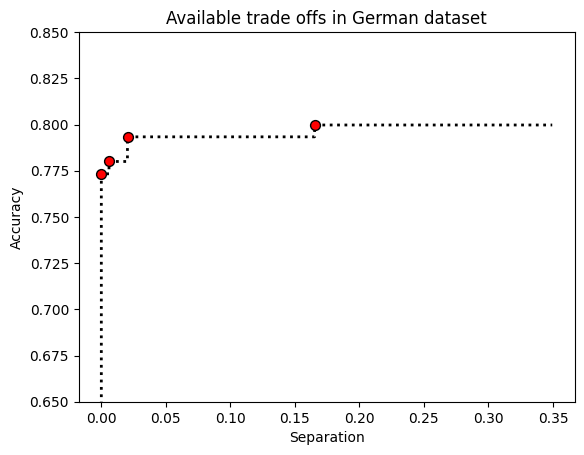

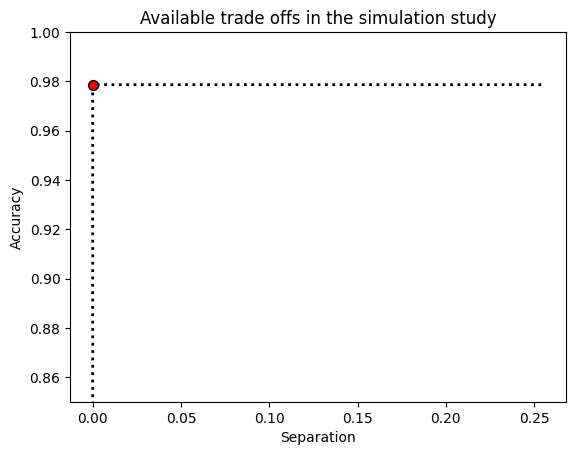

In [85]:
total_dict, concrete_result = mix_results()

fig, ax = plot_pareto(total_dict['German'], 'separation', 'acc')
ax.set_title("Available trade offs in German dataset")
ax.set_ylim((0.65, 0.85))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Separation')
plt.show()
fig.savefig('results/Figures/pareto/pareto_German')


fig, ax = plot_pareto(total_dict['Simulation'], 'separation', 'acc')
ax.set_title("Available trade offs in the simulation study")
ax.set_ylim((0.85, 1.))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Separation')
plt.show()
fig.savefig('results/Figures/pareto/pareto_Simulation')

We can visualize the Pareto efficient frontier for each individual case:

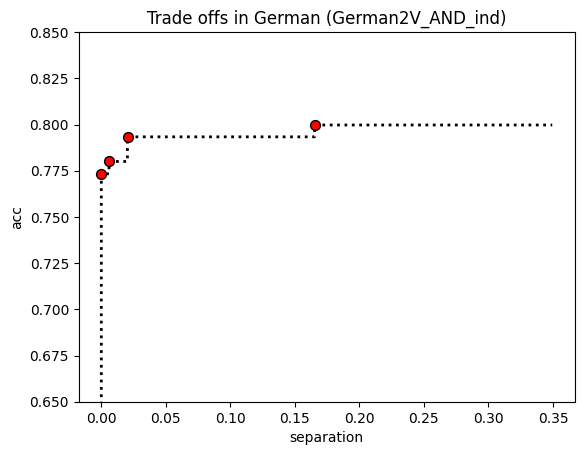

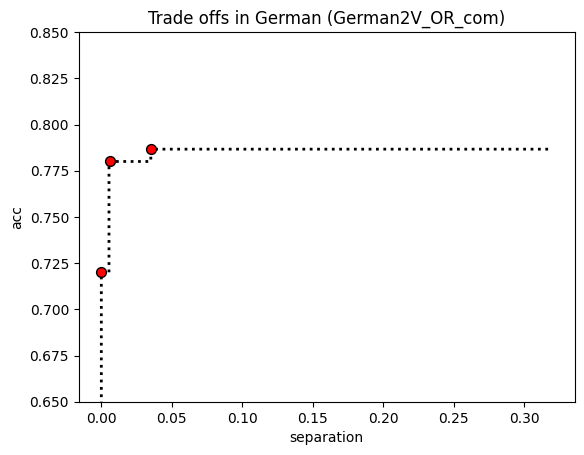

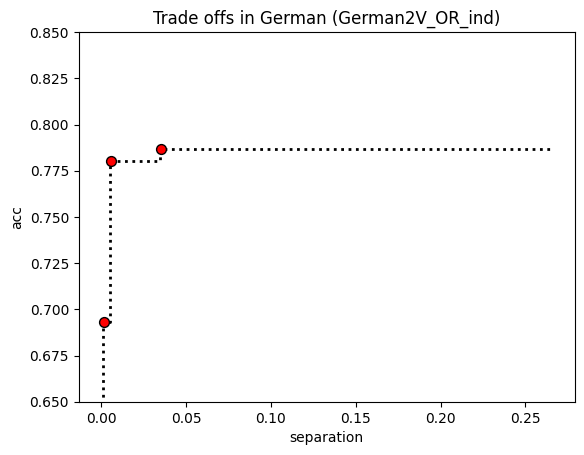

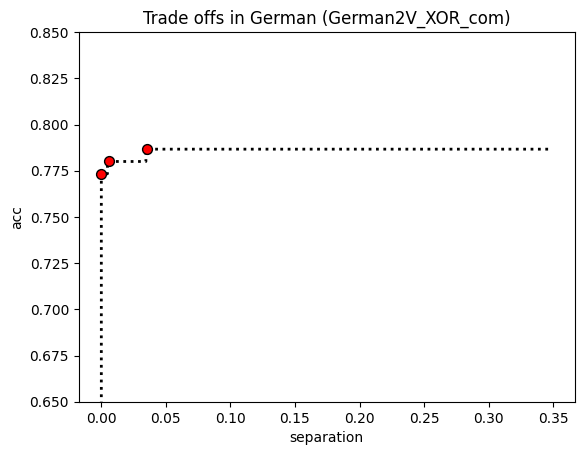

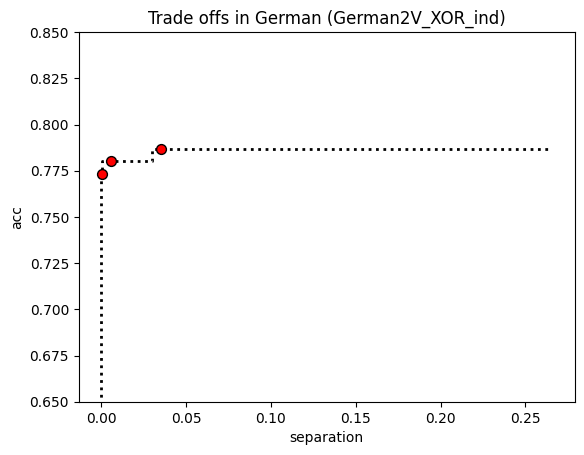

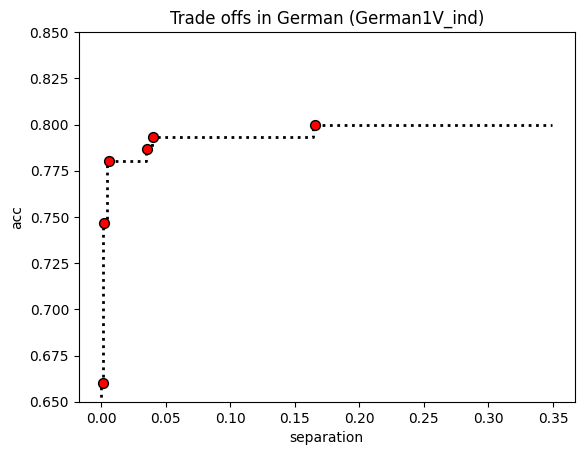

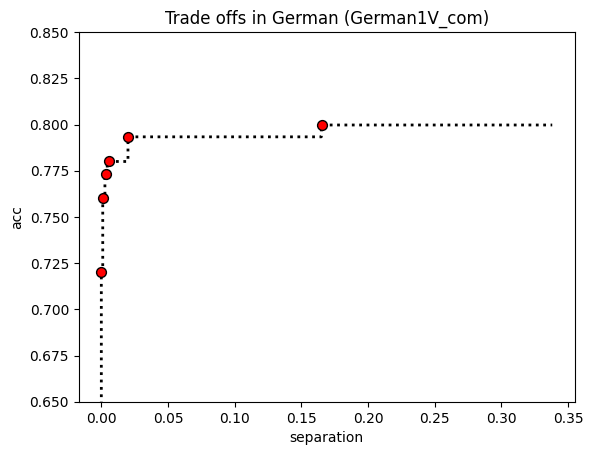

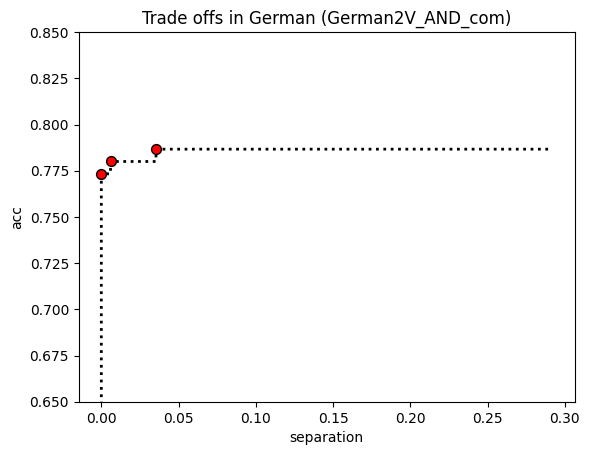

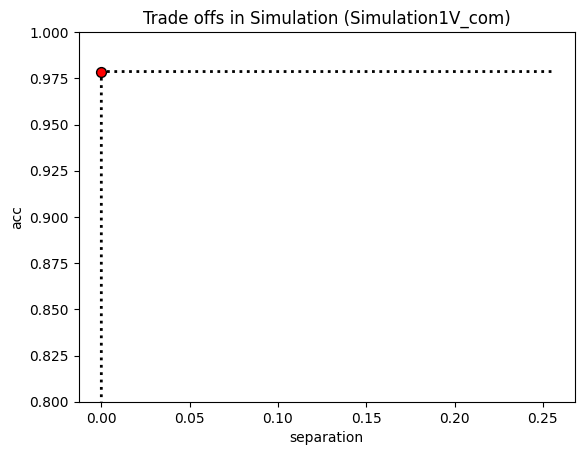

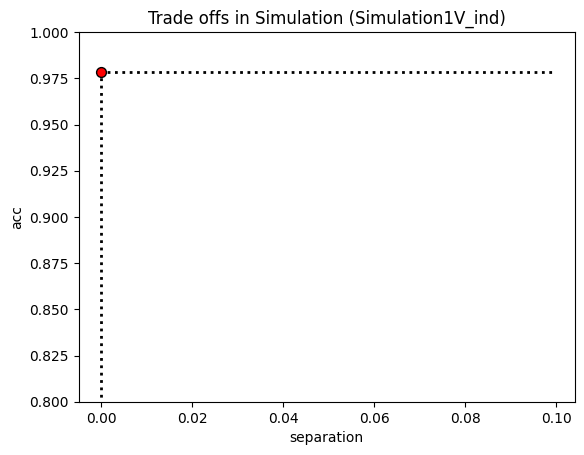

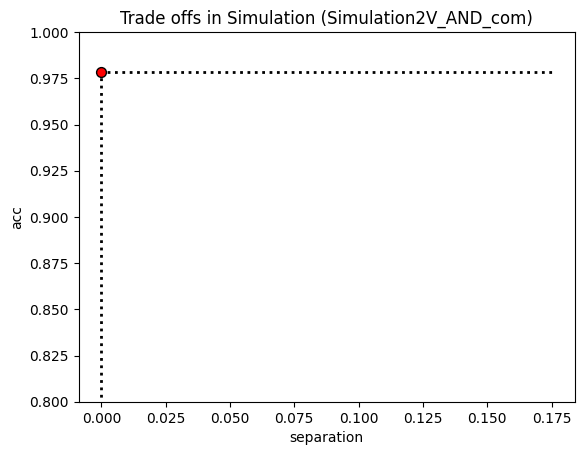

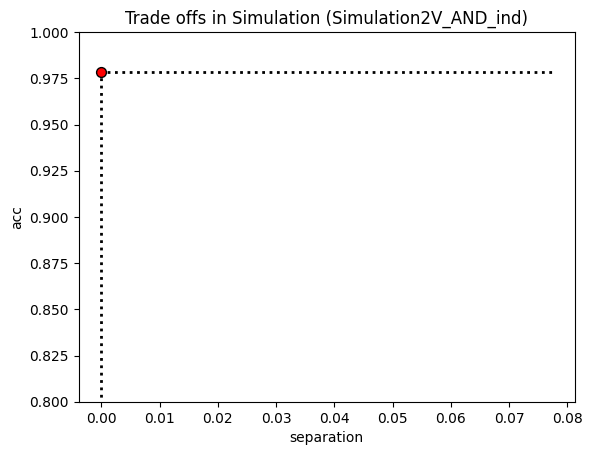

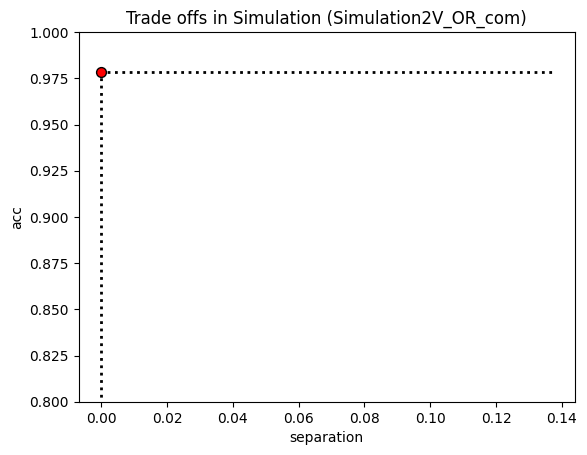

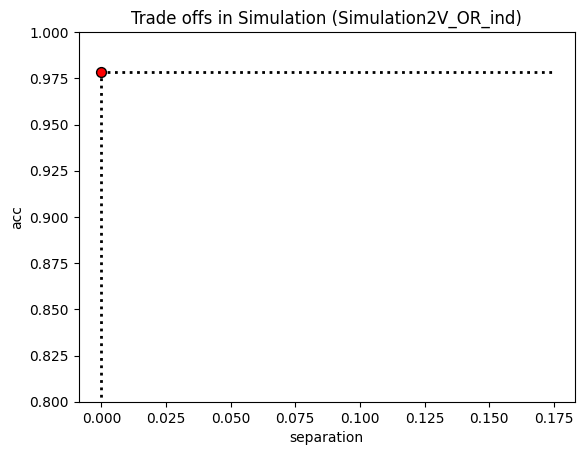

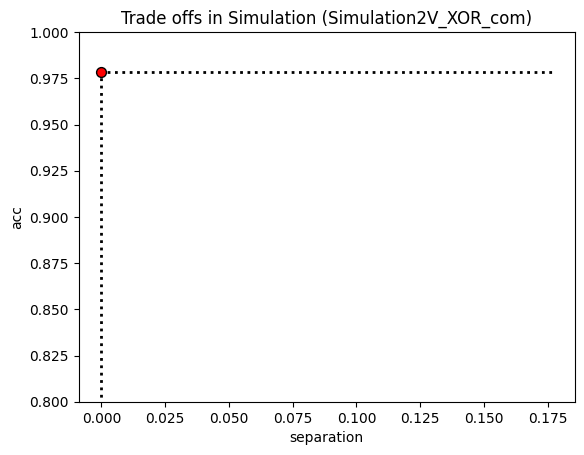

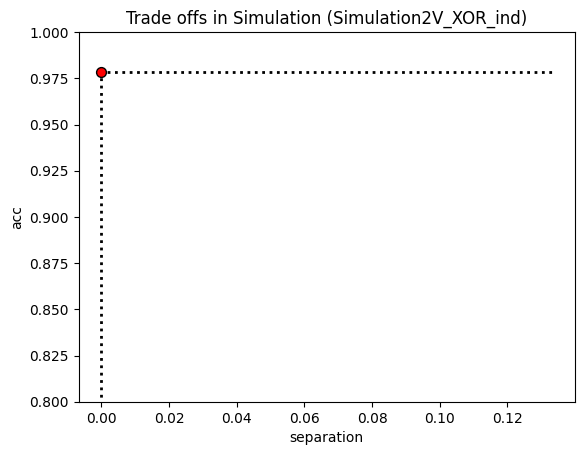

In [87]:
for dataset in datasets:
    for case in sweepsDict[dataset]:
        fig, ax = plot_pareto(concrete_result[dataset][case], 'separation', 'acc')
        if dataset == 'German':
            ax.set_ylim((0.65, 0.85))
        else:
            ax.set_ylim((0.8, 1.))
        ax.set_title("Trade offs in " + dataset + " (" + case + ")")

# Heatmap plot

We now show how to generate the heatmaps we used to visualize the performance of the methods.

In [ ]:
# Name of the processors
preproc = ['RW', 'DI']
inproc = ['meta', 'pir', 'advs']
postproc = ['Platt', 'eqOdds', 'RejOpt']
proc = preproc + inproc + postproc

# Names that should be used in case one method appears individually (i.e. we put logistic regreesion for pre processors)
default_labels = {
    'RW': 'RW_logreg',
    'DI': 'DI_logreg',
    'advs': 'advs',
    'meta': 'meta_sr',
    'pir': 'pir',
    'Platt': 'Platt',
    'eqOdds': 'eqOdds',
    'RejOpt': 'RejOpt_spd'
    }


def combination_matrix(resultsInd: pd.DataFrame, resultsCom: pd.DataFrame) -> dict[pd.DataFrame]:
    """
    Store results of individual and combined performance in the same data frame
    ======================================================================================================
    Inputs:
        resultsInd (pd.DataFrame): Data frame that stores the results of the individual methods.
        resultsCom (pd.DataFrame): Data frame that stores the results of the MP processors.

    Outputs:
        matrices (dict): dictionary whose entries are a data frame for each metric which stores the combined
            results for each one.
    """

    # Create the dictinoary
    matrices = dict()
    # Select metrics
    metrics = ['acc', 'bal_acc', 'independence', 'separation', 'sufficiency']
    # Initialize the reuslts of each metric as an empty data frame
    for metric in metrics:
        matrices[metric] = pd.DataFrame(np.nan, index=proc, columns=proc)

    # Iterate to generate the matric
    for index1 in proc:
        for index2 in proc:
            # Illegal combinations:
            # We use this iteration to store the results of individual methods.
            # We store the results of index1.
            if \
                (index1 in preproc and index2 in preproc) or \
                (index1 in inproc and index2 in inproc) or \
                (index1 in postproc and index2 in postproc):

                # Select the correct name
                if index1 in postproc:
                    nameUse = 'logreg_' + default_labels[index1]
                else:
                    nameUse = default_labels[index1]

                # Store individual results
                for metric in metrics:
                    matrices[metric].loc[index1, index2] = resultsInd.loc[nameUse, metric]

            # Allowed combinations
            else:
                
                # If the entry is empty:
                if np.isnan(matrices[metric].loc[index1, index2]):
                    # Use the correct name
                    if (index1 in preproc and index2 in inproc):
                        method_name = index1 + '_' + index2
                    else:
                        method_name = default_labels[index1] + '_' + default_labels[index2]                    
                    
                    # Store the combined performance in [index1, index2] and [index2, index1].
                    for metric in metrics:
                        matrices[metric].loc[index1, index2] = resultsCom.loc[method_name, metric]
                        matrices[metric].loc[index2, index1] = resultsCom.loc[method_name, metric]
                    
    return matrices


def plot_heat_combination_matrix(meanInd: pd.DataFrame, meanCom: pd.DataFrame, 
                                      stdInd: pd.DataFrame, stdCom: pd.DataFrame, 
                                      metric: str, invert_color: bool = True):
    """
    Heatmap plot that shows the performance of the combination of methods
    ======================================================================================================
    Inputs:
        resultsInd (pd.DataFrame): Data frame that stores the results of the individual methods.
        resultsCom (pd.DataFrame): Data frame that stores the results of the MP processors.
        metric (str): Name of the metric we are interested in visualizing.

    Outputs:
        fig, ax (plt.figure, plt.axes): plt objects that store the plot we produce.
    """
    
    matrix_vals = pd.DataFrame(np.nan, index=proc, columns=proc)
    matrix_annot = pd.DataFrame("", index=proc, columns=proc)
    
    baseline_mean = meanInd.loc['logreg', metric] if 'logreg' in meanInd.index else 0
    
    for index1 in proc:
        for index2 in proc:
            
            is_group_match = (
                (index1 in preproc and index2 in preproc) or
                (index1 in inproc and index2 in inproc) or
                (index1 in postproc and index2 in postproc)
            )

            if is_group_match:
                if index1 in postproc:
                    nameUse = 'logreg_' + default_labels[index1]
                else:
                    nameUse = default_labels[index1]
                
                try:
                    val_mean = meanInd.loc[nameUse, metric]
                    val_std = stdInd.loc[nameUse, metric]
                    
                    diff = val_mean - baseline_mean
                    matrix_vals.loc[index1, index2] = diff
                    matrix_annot.loc[index1, index2] = f"{diff:.2f}\n±{val_std:.2f}"
                except KeyError:
                    pass

            else:
                if np.isnan(matrix_vals.loc[index1, index2]):
                    if (index1 in preproc and index2 in inproc):
                        method_name = index1 + '_' + index2
                    else:
                        method_name = default_labels[index1] + '_' + default_labels[index2]
                    
                    try:
                        val_mean = meanCom.loc[method_name, metric]
                        val_std = stdCom.loc[method_name, metric]
                        
                        diff = val_mean - baseline_mean
                        
                        matrix_vals.loc[index1, index2] = diff
                        matrix_vals.loc[index2, index1] = diff
                        
                        label = f"{diff:.2f}\n±{val_std:.2f}"
                        matrix_annot.loc[index1, index2] = label
                        matrix_annot.loc[index2, index1] = label
                    except KeyError:
                        pass

    fig, ax = plt.subplots(figsize=(6, 6))

    mask = np.triu(np.ones_like(matrix_vals, dtype=bool), k=1)
    mask[0:2, 0:2] = True
    mask[2:5, 2:5] = True
    mask[5:, 5:] = True
    np.fill_diagonal(mask, False)

    max_val = matrix_vals.max().max()
    min_val = matrix_vals.min().min()
    
    if pd.isna(max_val) or pd.isna(min_val):
        v_lim = 0.05
    else:
        v_lim = max(abs(max_val), abs(min_val))
        if v_lim == 0: v_lim = 0.05
    cmap = "RdBu" if invert_color else "RdBu_r"
    norm = plt.Normalize(vmin=matrix_vals.min().min(), vmax=matrix_vals.max().max())

    sns.heatmap(
        matrix_vals,
        mask=mask,
        annot=matrix_annot.values,
        fmt="",
        linewidth=0.5,
        ax=ax,
        cmap=cmap,
        vmin=-v_lim, 
        vmax=v_lim,
        center=0,
        annot_kws={"size": 8}
    )

    ax.set_xlabel("Fairness processor")
    ax.set_ylabel("Fairness processor")
    
    return fig, ax

We can now generate the performance heatmaps using the following code:

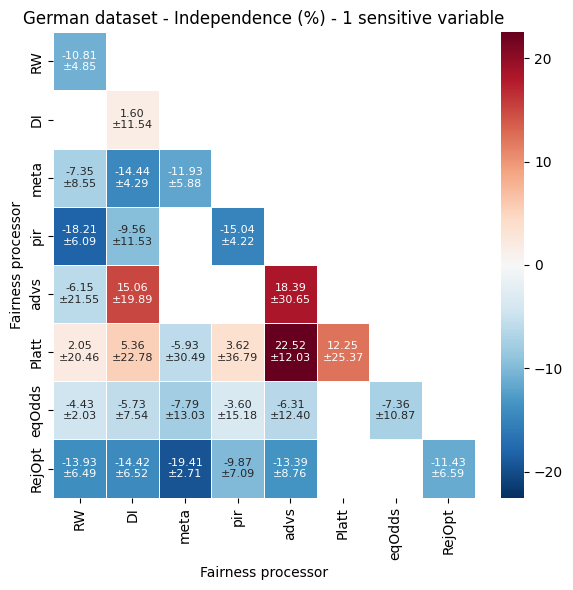

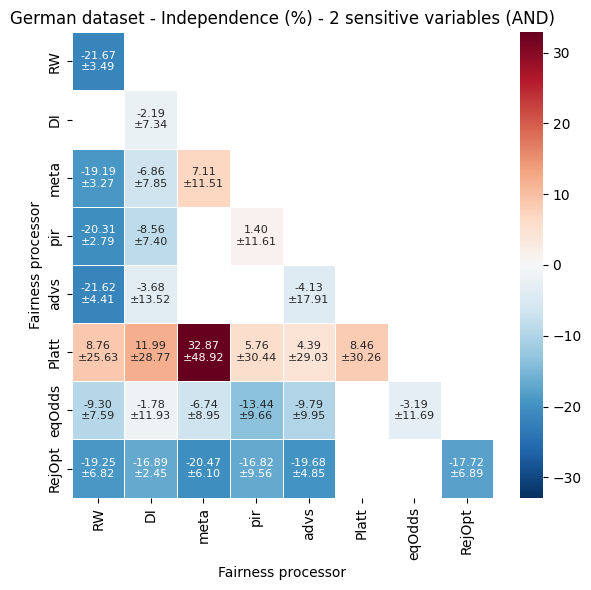

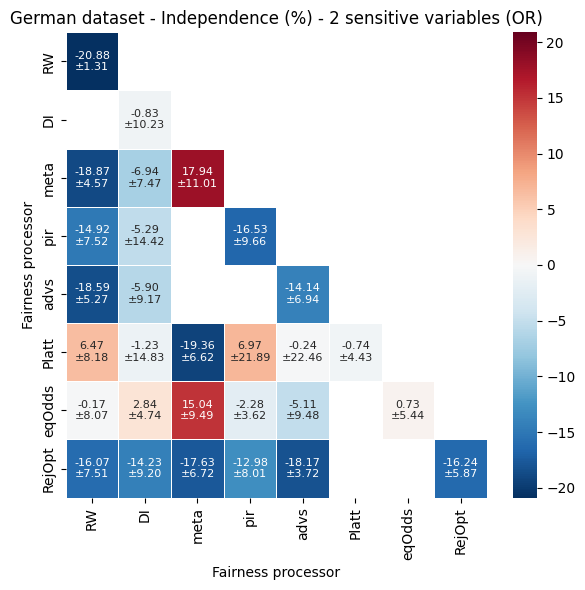

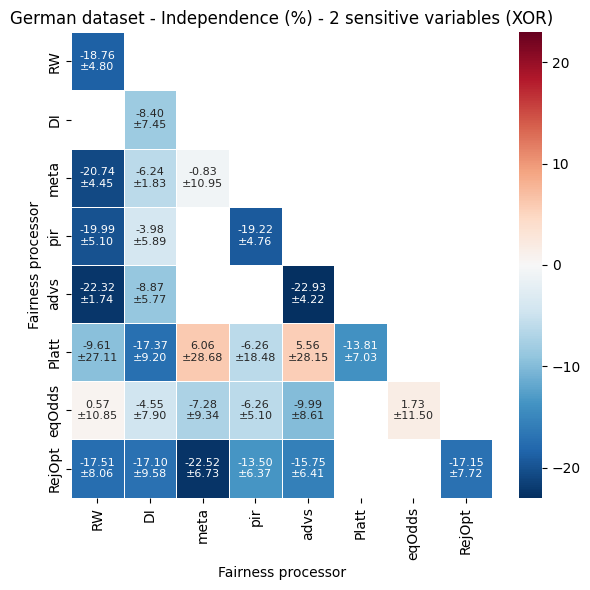

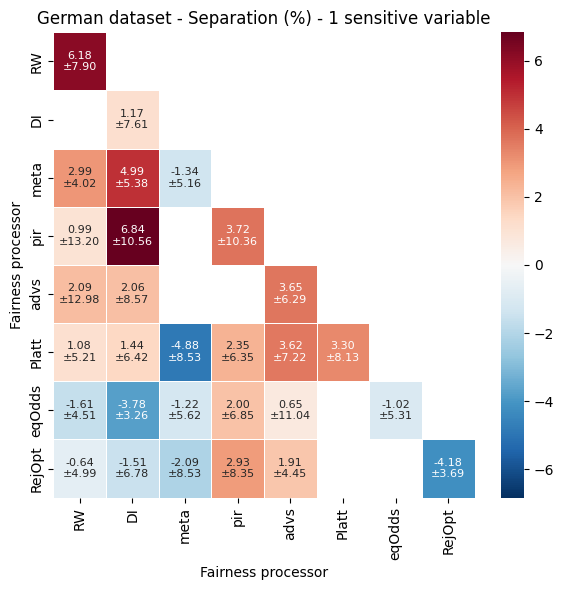

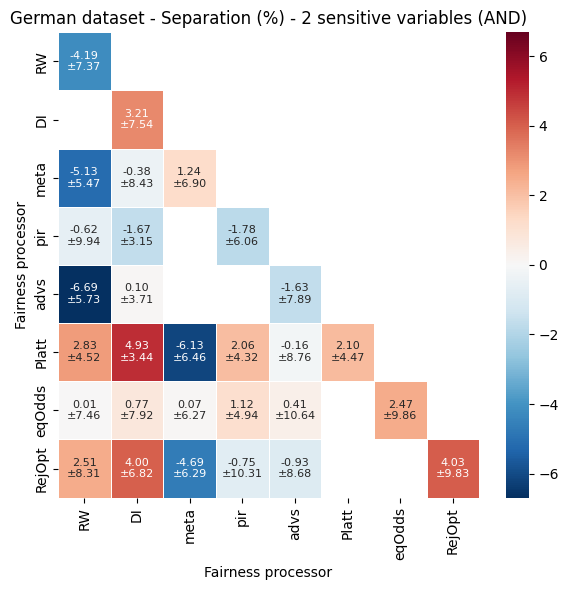

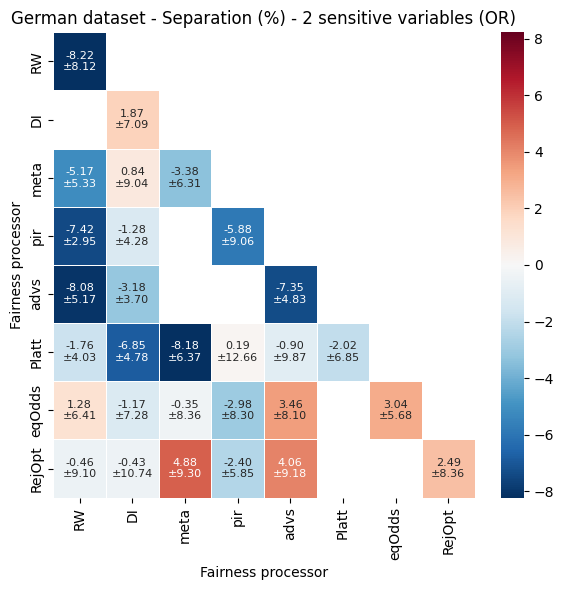

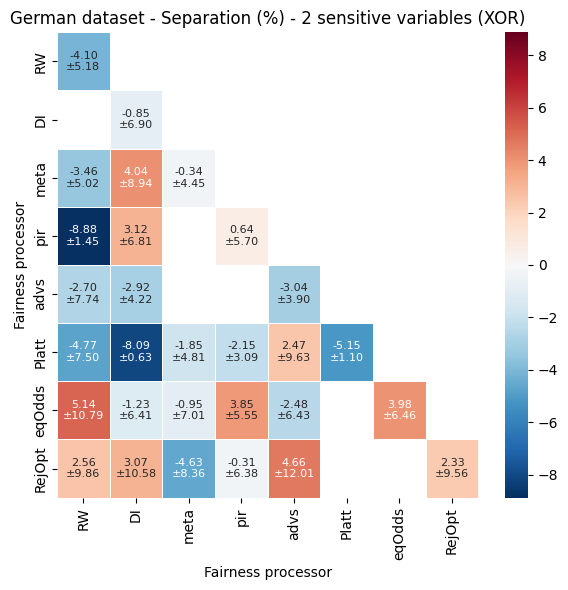

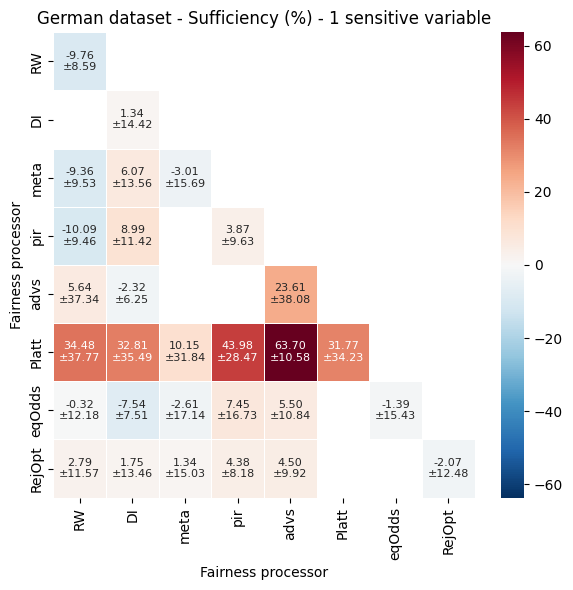

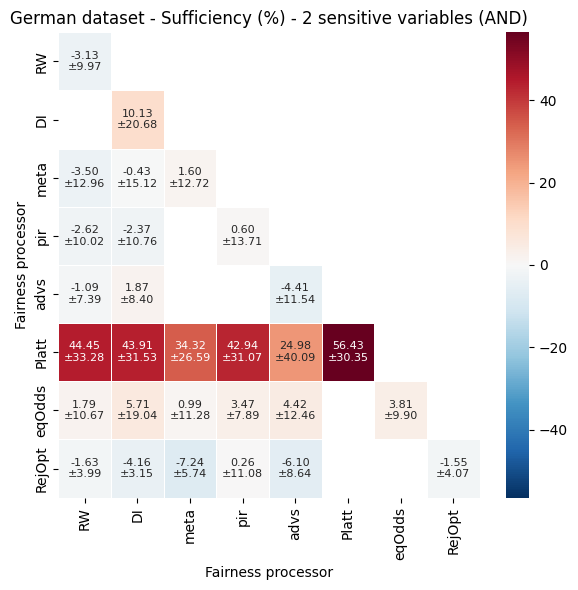

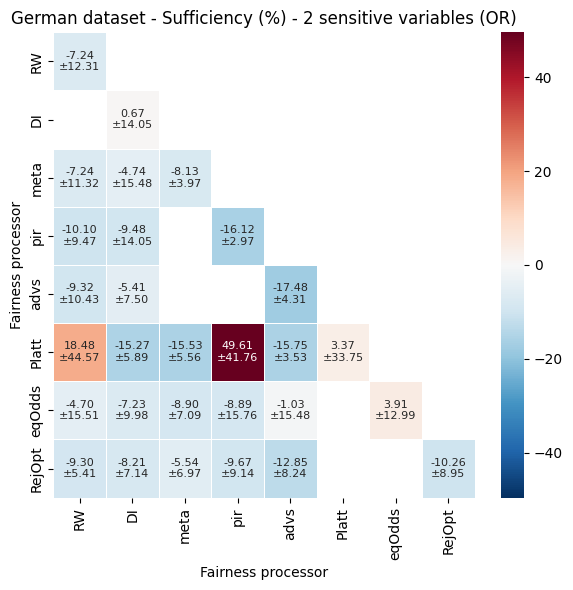

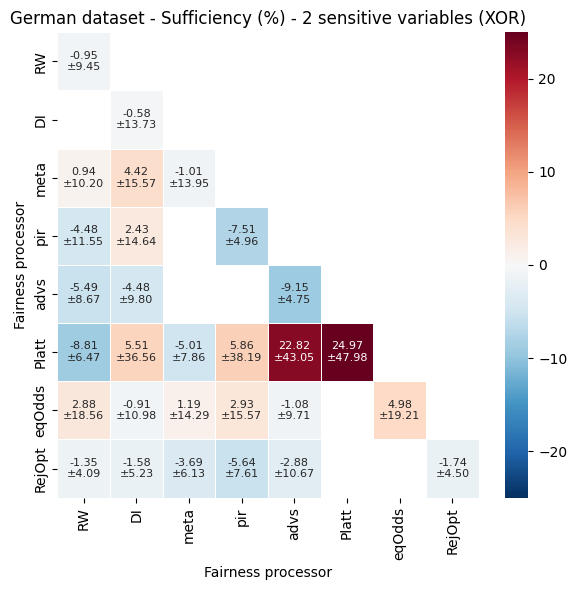

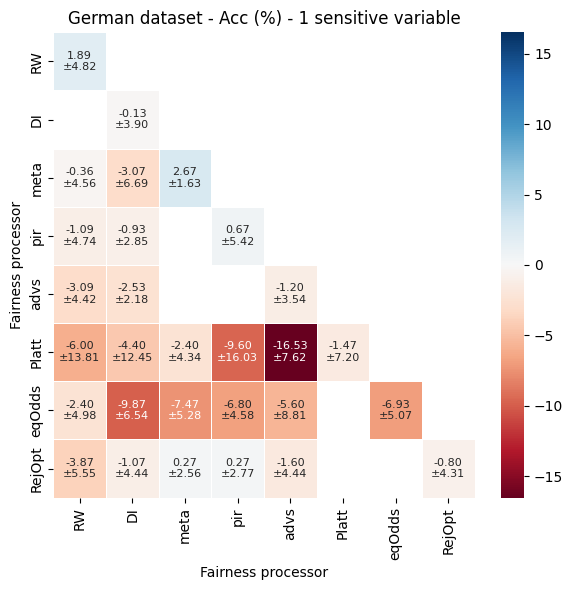

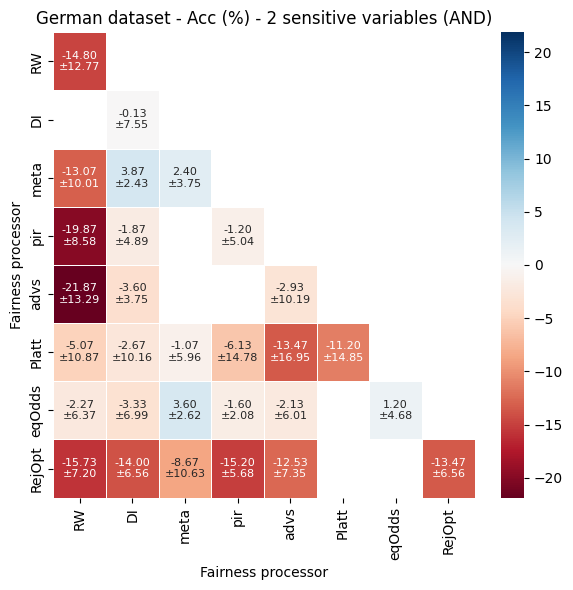

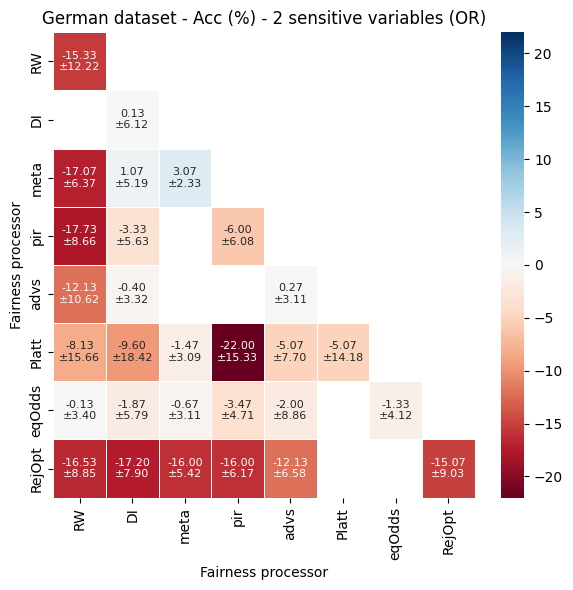

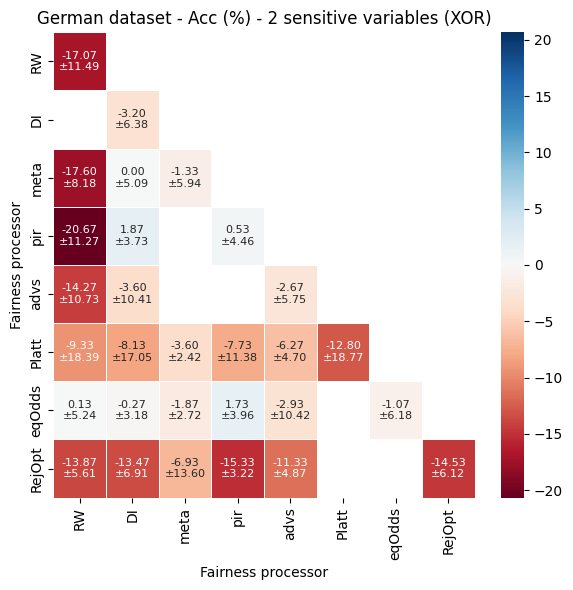

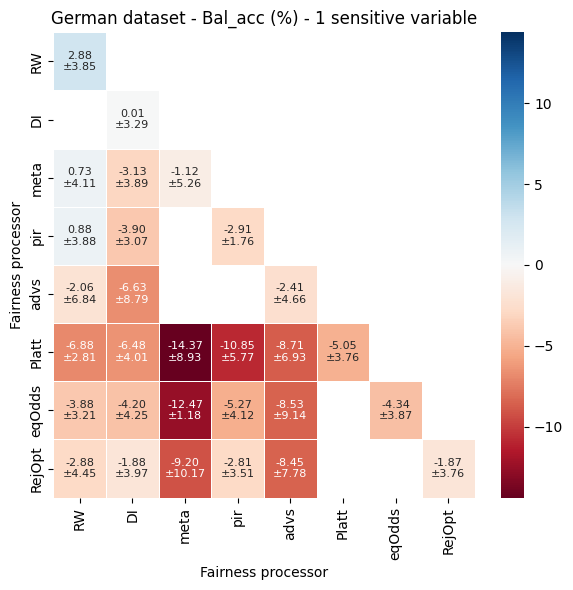

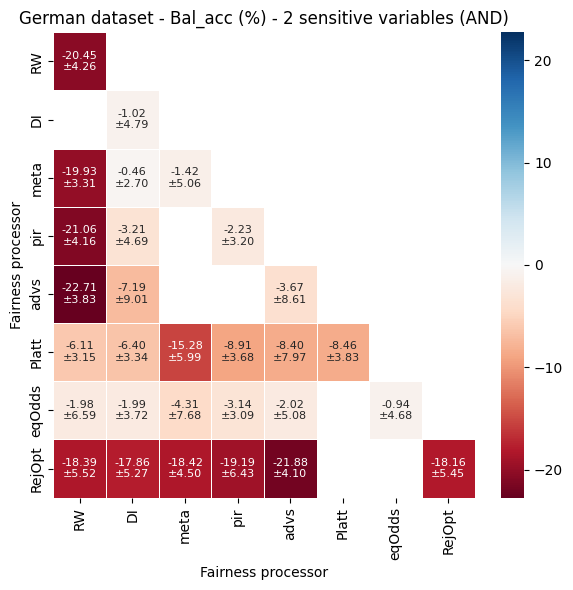

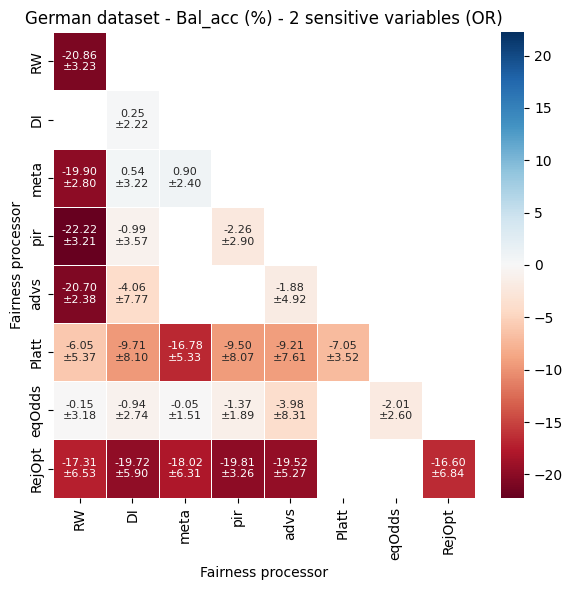

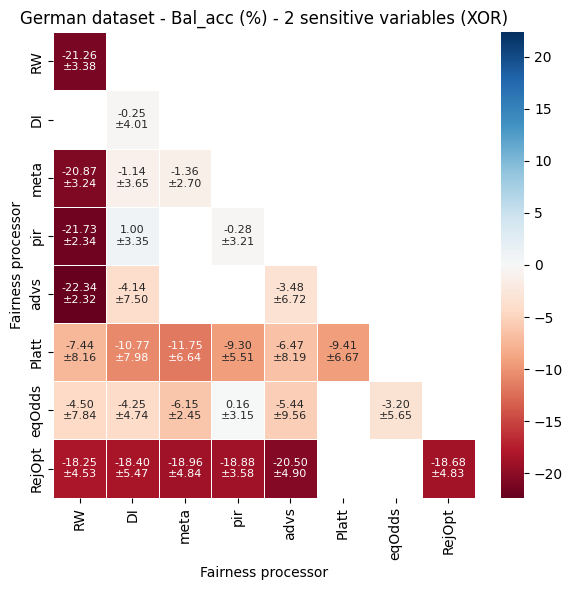

In [102]:
metrics = ['independence', 'separation', 'sufficiency', 'acc', 'bal_acc']

for metric in metrics:
    invert_color = True if (metric == 'acc' or metric == 'bal_acc') else False

    fig, ax = plot_heat_combination_matrix(meanResults['German']['German1V_ind'], meanResults['German']['German1V_com'], stdResults['German']['German1V_ind'], stdResults['German']['German1V_com'], metric, invert_color = invert_color)
    ax.set_title(f"German dataset - {metric.capitalize()} (%) - 1 sensitive variable")
    plt.tight_layout()
    plt.show()
    fig.savefig('results/Figures/performance_matrix/' + metric + '/German1V_' + metric + '.png')

    fig, ax = plot_heat_combination_matrix(meanResults['German']['German2V_AND_ind'], meanResults['German']['German2V_AND_com'], stdResults['German']['German2V_AND_ind'], stdResults['German']['German2V_AND_com'], metric, invert_color = invert_color)
    ax.set_title(f"German dataset - {metric.capitalize()} (%) - 2 sensitive variables (AND)")
    plt.tight_layout()
    plt.show()
    fig.savefig('results/Figures/performance_matrix/' + metric + '/German2V_AND_' + metric + '.png')

    fig, ax = plot_heat_combination_matrix(meanResults['German']['German2V_OR_ind'], meanResults['German']['German2V_OR_com'], stdResults['German']['German2V_OR_ind'], stdResults['German']['German2V_OR_com'], metric, invert_color = invert_color)
    ax.set_title(f"German dataset - {metric.capitalize()} (%) - 2 sensitive variables (OR)")
    plt.tight_layout()
    plt.show()
    fig.savefig('results/Figures/performance_matrix/' + metric + '/German2V_OR_' + metric + '.png')

    fig, ax = plot_heat_combination_matrix(meanResults['German']['German2V_XOR_ind'], meanResults['German']['German2V_XOR_com'], stdResults['German']['German2V_XOR_ind'], stdResults['German']['German2V_XOR_com'], metric, invert_color = invert_color)
    ax.set_title(f"German dataset - {metric.capitalize()} (%) - 2 sensitive variables (XOR)")
    plt.tight_layout()
    plt.show()
    fig.savefig('results/Figures/performance_matrix/' + metric + '/German2V_XOR_' + metric + '.png')

# Radar plot

We now show how to create radar plot to better observe the interaction between methods.

In [ ]:
def plot_radar(resultsInd: pd.DataFrame, resultsCom: pd.DataFrame, method1: str, method2: str):
    """
    Radar plot that shows the performance of two methods and their combination
    ======================================================================================================
    Inputs:
        resultsInd (pd.DataFrame): Data frame that stores the results of the individual methods.
        resultsCom (pd.DataFrame): Data frame that stores the results of the MP processors.
        method1 (str): Name of the method that acts first in the ML pipeline.
        method2 (str): Name of the method that acts last in the ML pipeline.

    Outputs:
        fig, ax (plt.figure, plt.axes): plt objects that store the plot we produce.
    """

    # Labels that we need to use for individual methods (i.e. use logistic regression in pre and post processing)
    default_labels = {
        'RW': 'RW_logreg',
        'DI': 'DI_logreg',
        'adversarial': 'adversarial',
        'metafair': 'metafair_sr',
        'pir': 'pir',
        'Platt': 'logreg_Platt',
        'eqOdds': 'logreg_eqOdds',
        'RejOpt': 'logreg_RejOpt_spd',
        'RejOpt_aod': 'logreg_RejOpt_aod'
        }

    # Assign the correct name to the combination of processors
    if \
        (method1 in preproc and method2 in inproc) or \
        (method1 in inproc and method2 in postproc):
        com_name = method1 + '_' + method2
    else:
        com_name = default_labels[method1] + '_' + default_labels[method2]  

    # Metrics that will be used in the radar graph
    cathegories = ['acc', 'bal_acc', 'independence', 'separation', 'sufficiency']

    # Dictionaries that will store the values for these metrics
    values = dict()
    values[method1] = dict()
    values[method2] = dict()
    values[com_name] = dict()

    # Store the values of each metrics. Append the first value at the end to make the correct circular graph
    values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
    values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]] 
    values[com_name] = resultsCom.loc[com_name, cathegories].tolist() + [resultsCom.loc[com_name, cathegories][0]]

    # Compute the angles of the polar graph
    N = len(cathegories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.set_ylim(0, 1)
    ax.plot(angles, values[method1], label=method1, linewidth=3, alpha = 0.95, color = "#4169E1")
#    ax.fill(angles, values[method1], alpha=0.25)
    ax.plot(angles, values[method2], label=method2, linewidth=3, alpha = 0.95, color = "#f19600")
#    ax.fill(angles, values[method2], alpha=0.25)
    ax.plot(angles, values[com_name], label="combination", linewidth=3, alpha = 0.95, color = "#85006c")
#    ax.fill(angles, values[com_name], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cathegories)
    plt.legend()
    return fig, ax

We can now plot our results.

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

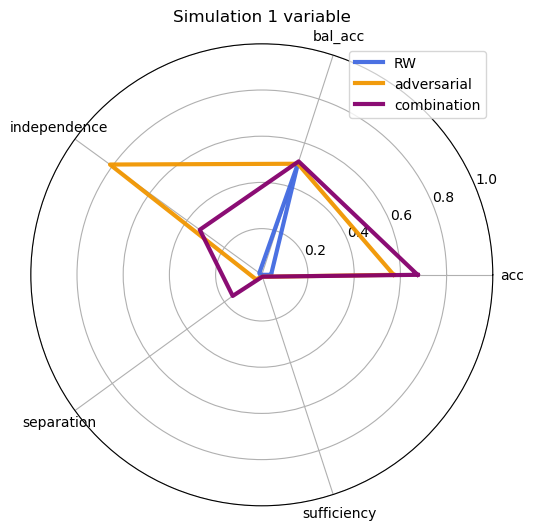

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

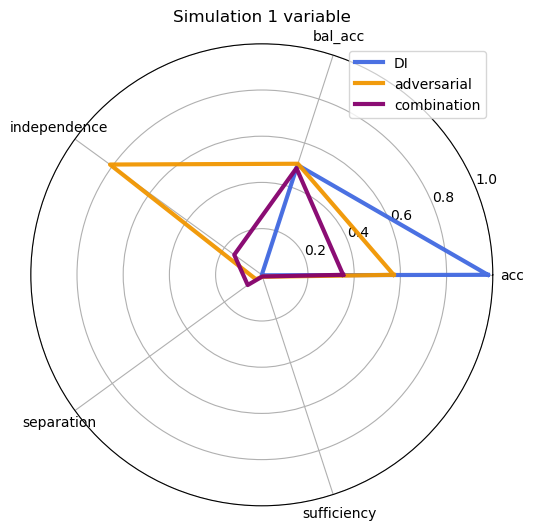

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

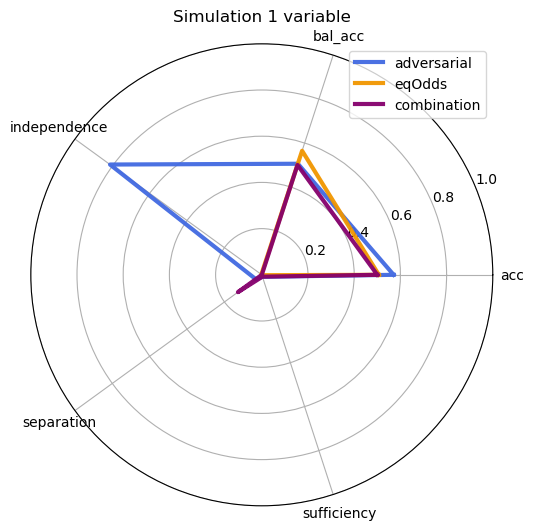

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

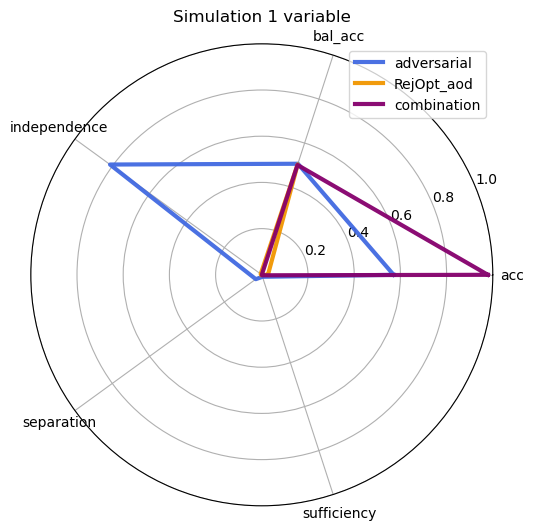

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

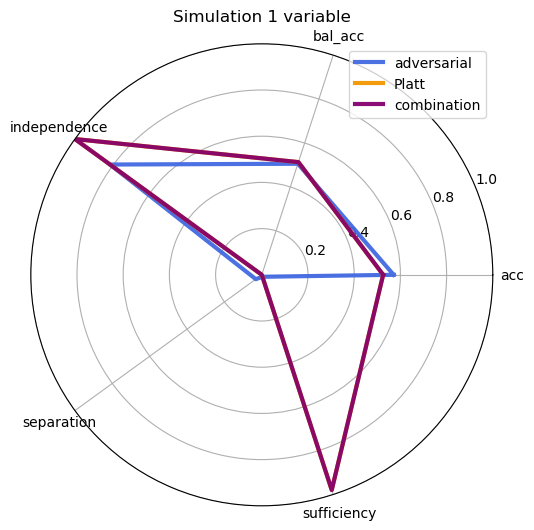

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

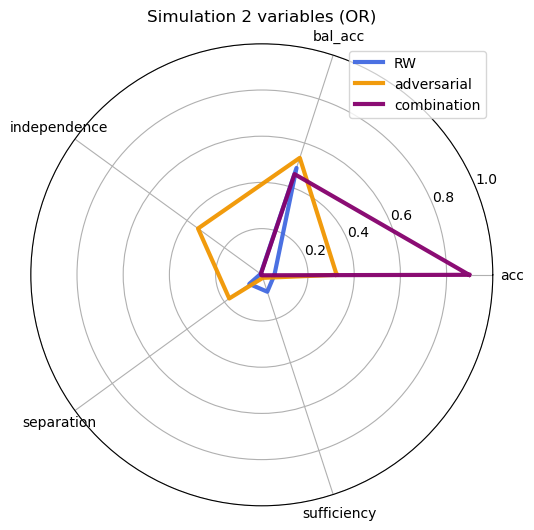

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

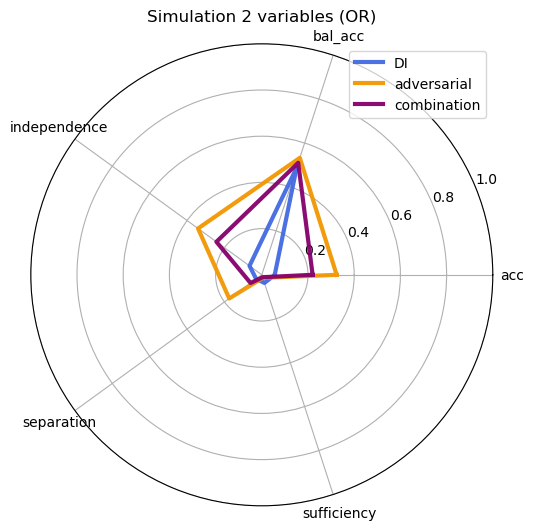

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

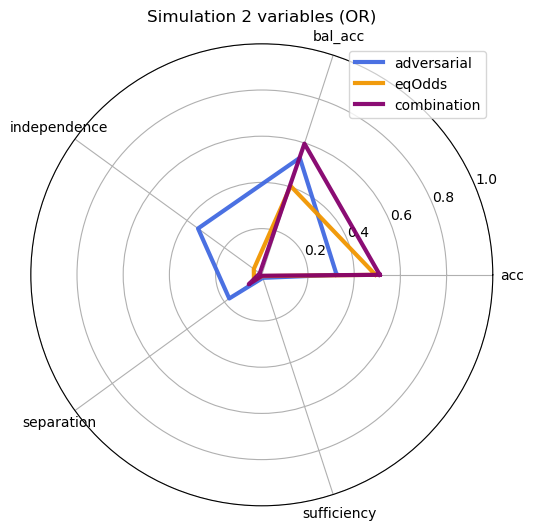

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

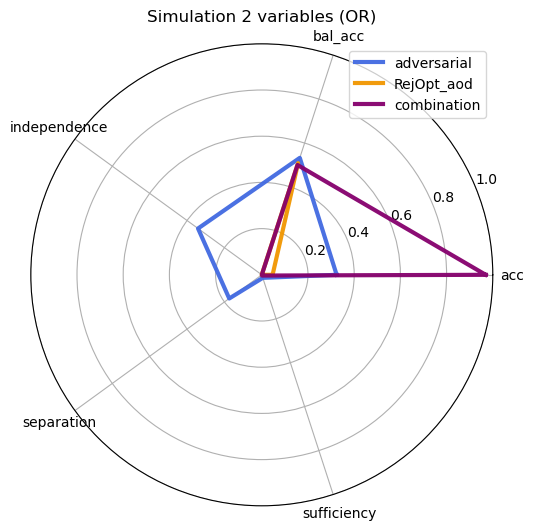

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

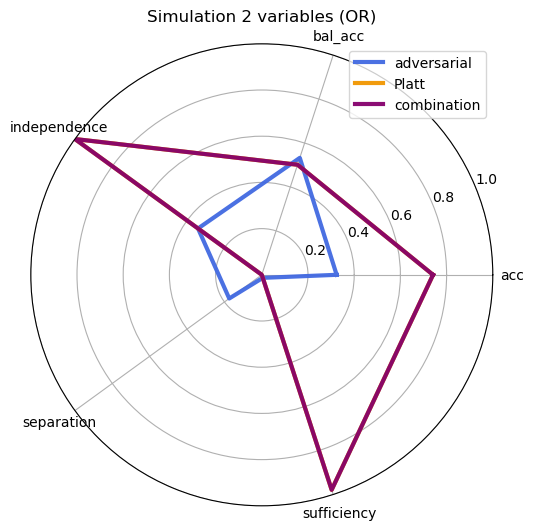

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

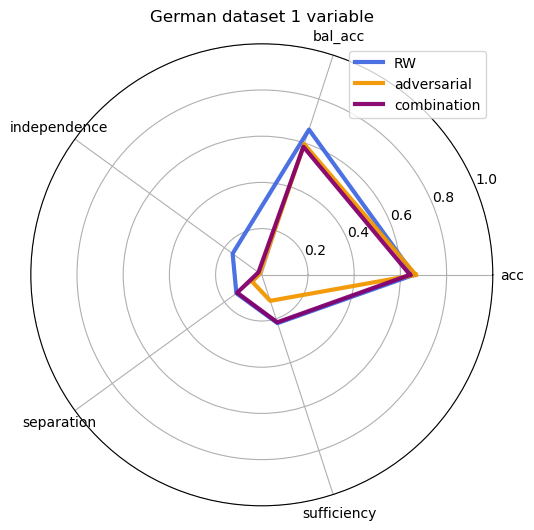

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

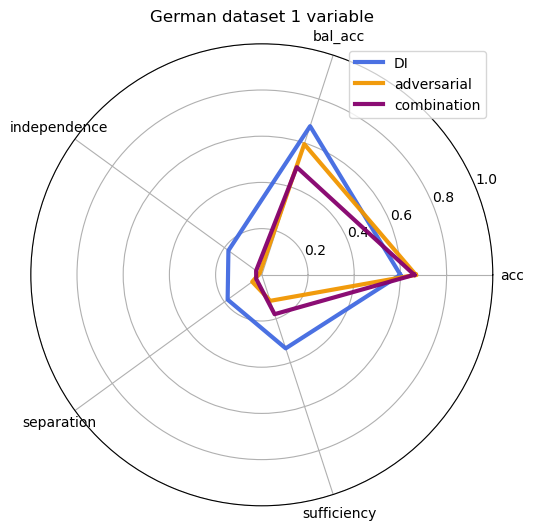

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

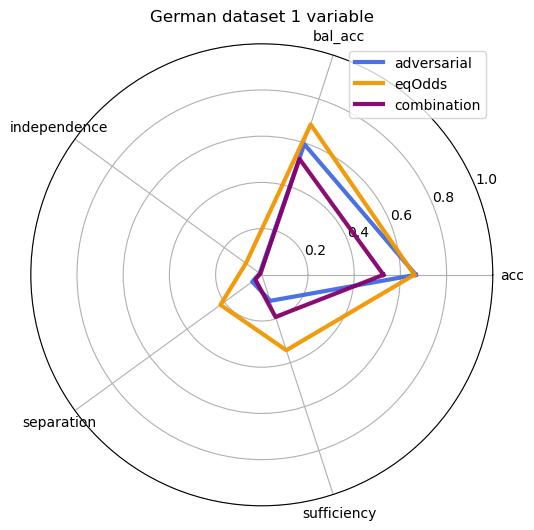

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

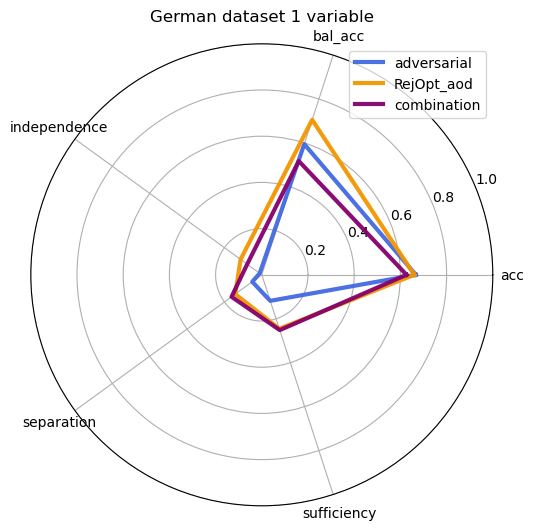

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

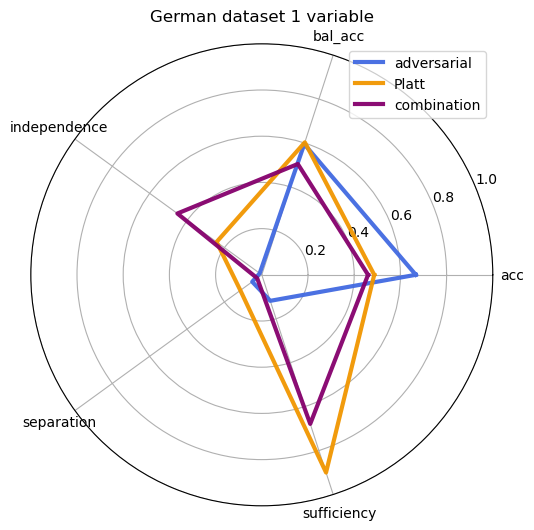

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

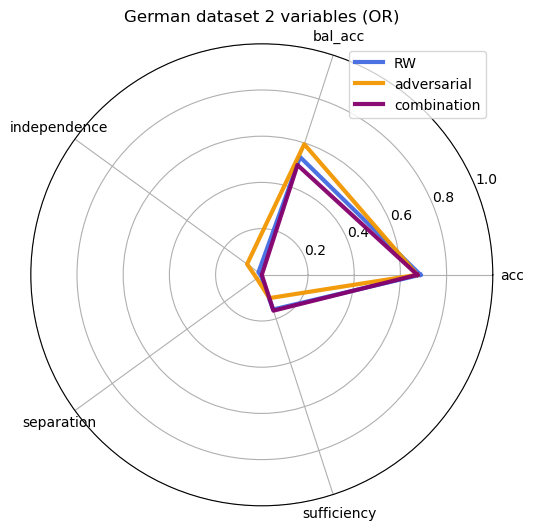

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

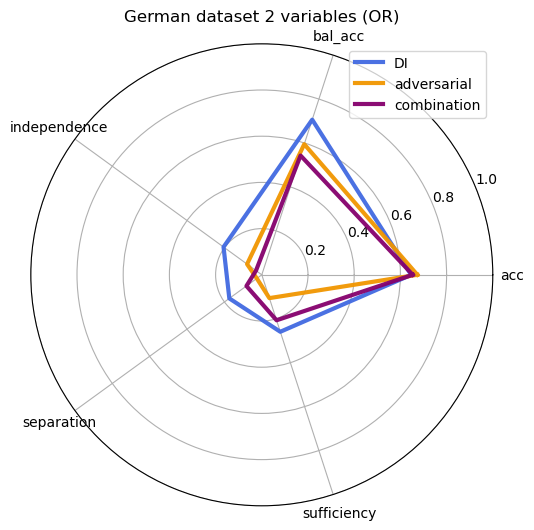

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

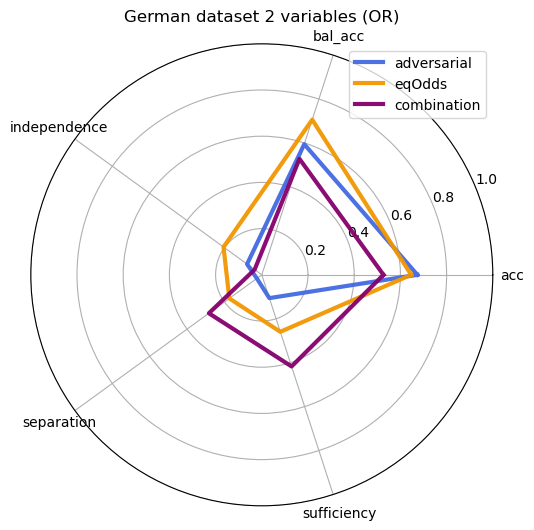

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

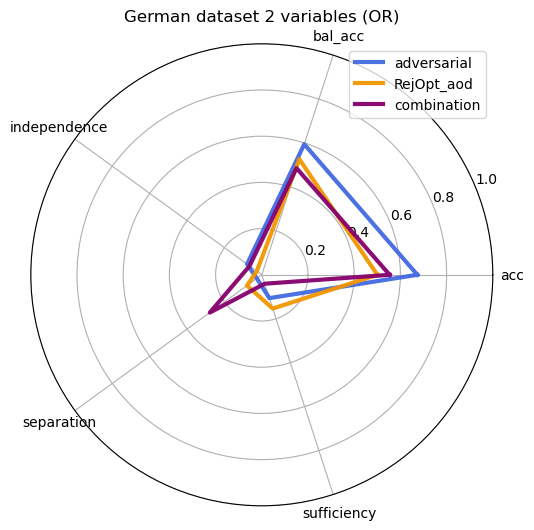

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

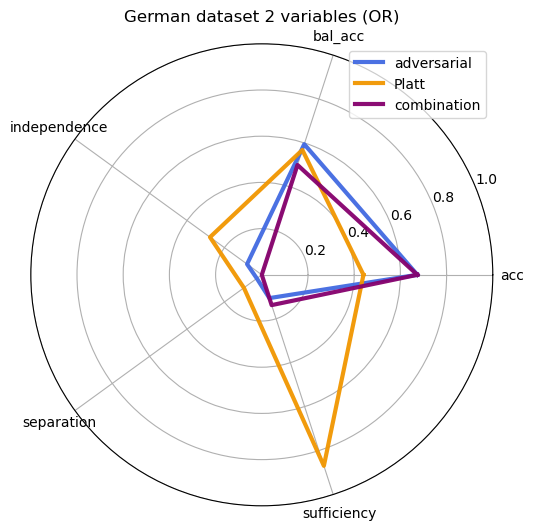

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

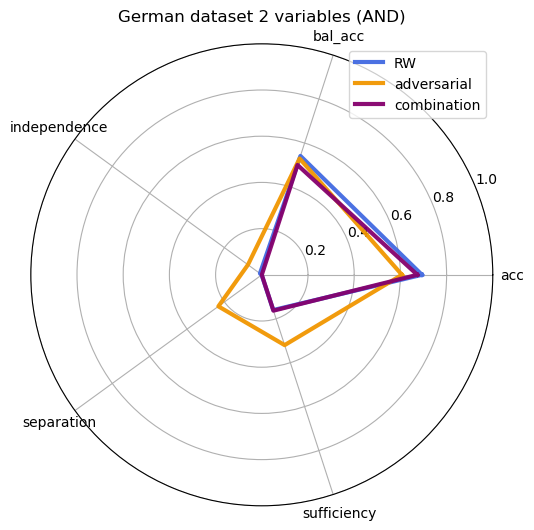

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

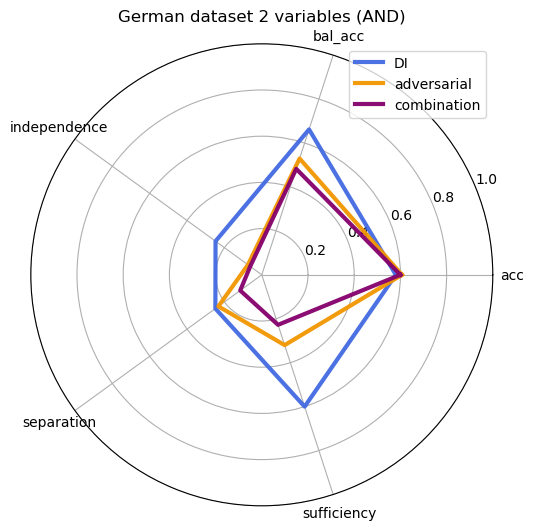

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

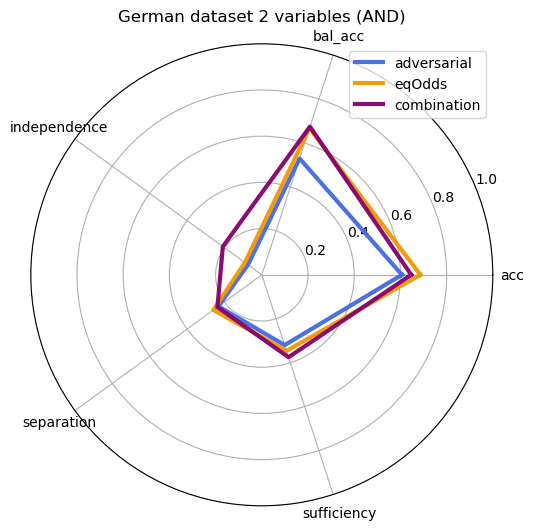

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

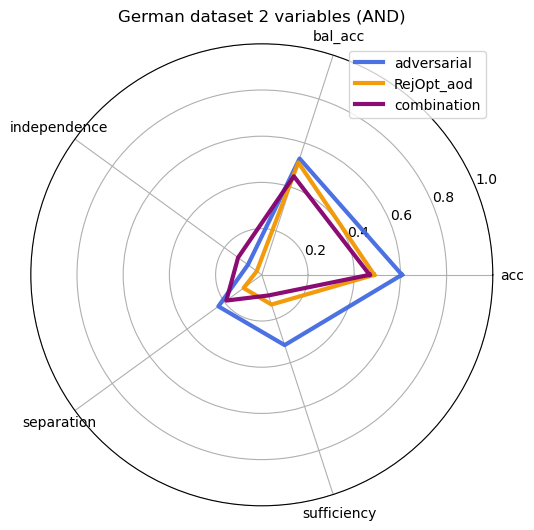

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

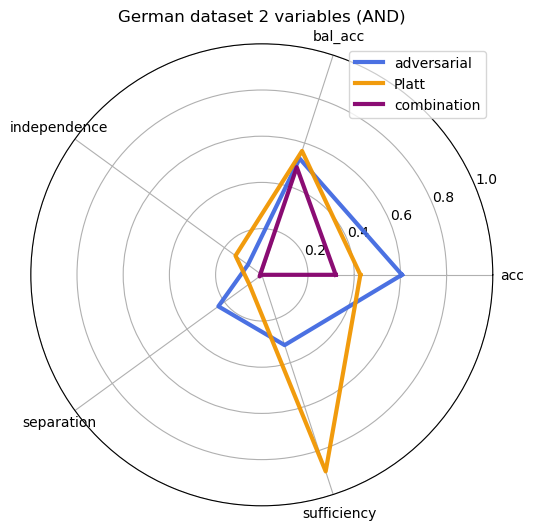

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

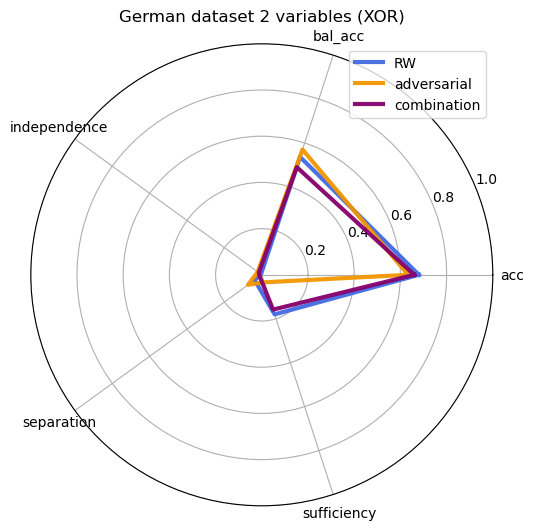

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

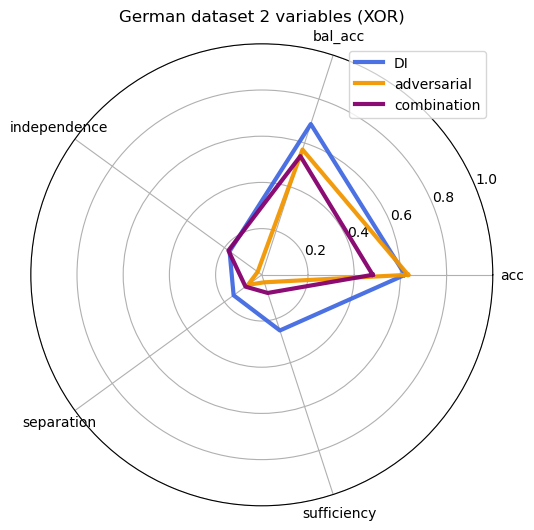

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

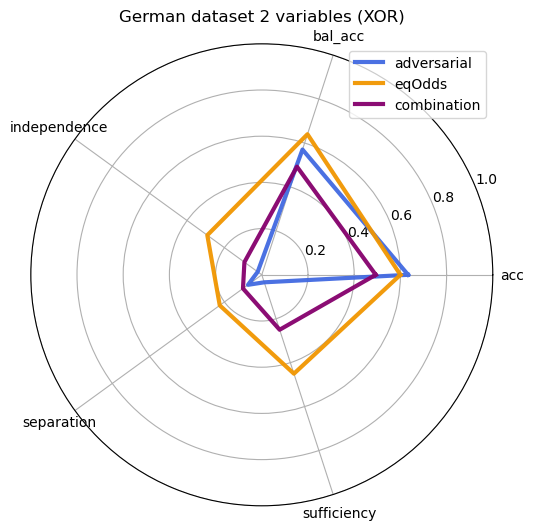

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

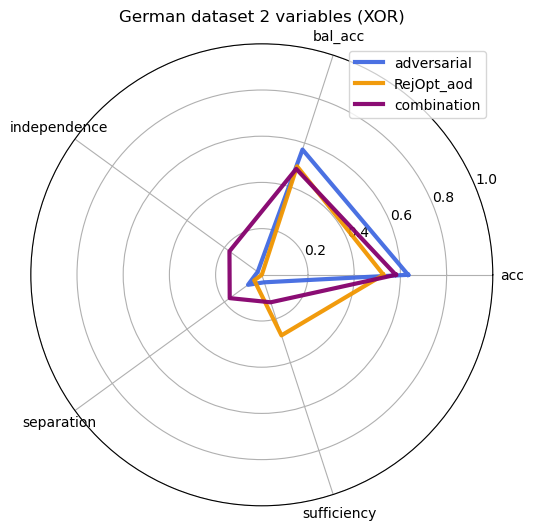

C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method1] = resultsInd.loc[default_labels[method1], cathegories].tolist() + [resultsInd.loc[default_labels[method1], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values[method2] = resultsInd.loc[default_labels[method2], cathegories].tolist() + [resultsInd.loc[default_labels[method2], cathegories][0]]
C:\Users\Arturo\AppData\Local\Temp\ipykernel_27020\3143979306.py:48: FutureWarning: Series.__getitem__ treating ke

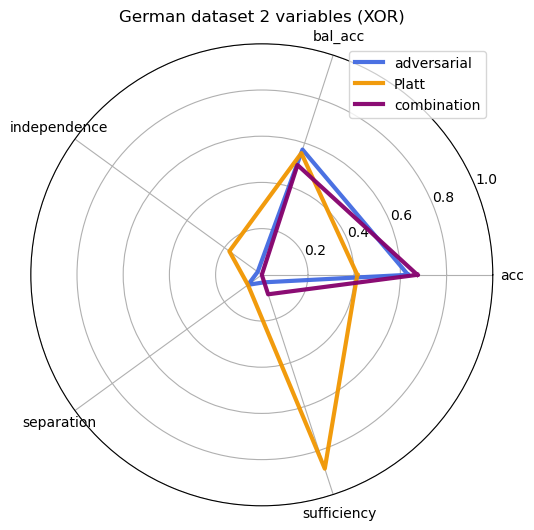

In [ ]:
preproc = ['RW', 'DI']
inproc = ['pir', 'adversarial', 'metafair']
postproc = ['eqOdds', 'RejOpt_aod', 'Platt']

for method in preproc:
    fig, ax = plot_radar(resultsDict['Simulation']['Simulation1V_indmeanResults'], resultsDict['Simulation']['Simulation1V_com_1'], method, 'adversarial')
    ax.set_title('Simulation 1 variable')
    plt.show()
    fig.savefig('results/Figures/performance_radar/Simulation1V_' + method + '+adversarial.png')
    

for method in postproc:
    fig, ax = plot_radar(resultsDict['Simulation']['Simulation1V_ind'], resultsDict['Simulation']['Simulation1V_com_1'], 'adversarial', method)
    ax.set_title('Simulation 1 variable')
    plt.show()
    fig.savefig('results/Figures/performance_radar/Simulation1V_adversarial+' + method + '.png')

for method in preproc:
    fig, ax = plot_radar(resultsDict['Simulation']['Simulation2V_OR_ind_1'], resultsDict['Simulation']['Simulation2V_OR_com_1'], method, 'adversarial')
    ax.set_title('Simulation 2 variables (OR)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/Simulation2V_OR_' + method + '+adversarial.png')

for method in postproc:
    fig, ax = plot_radar(resultsDict['Simulation']['Simulation2V_OR_ind_1'], resultsDict['Simulation']['Simulation2V_OR_com_1'], 'adversarial', method)
    ax.set_title('Simulation 2 variables (OR)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/Simulation2V_OR_adversarial+' + method + '.png')


for method in preproc:
    fig, ax = plot_radar(resultsDict['German']['German1V_ind_1'], resultsDict['German']['German1V_com_1'], method, 'adversarial')
    ax.set_title('German dataset 1 variable')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German1V_' + method + '+adversarial.png')
    

for method in postproc:
    fig, ax = plot_radar(resultsDict['German']['German1V_ind_1'], resultsDict['German']['German1V_com_1'], 'adversarial', method)
    ax.set_title('German dataset 1 variable')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German1V_adversarial+' + method + '.png')

for method in preproc:
    fig, ax = plot_radar(resultsDict['German']['German2V_OR_ind_1'], resultsDict['German']['German2V_OR_com_1'], method, 'adversarial')
    ax.set_title('German dataset 2 variables (OR)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German2V_OR_' + method + '+adversarial.png')

for method in postproc:
    fig, ax = plot_radar(resultsDict['German']['German2V_OR_ind_1'], resultsDict['German']['German2V_OR_com_1'], 'adversarial', method)
    ax.set_title('German dataset 2 variables (OR)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German2V_OR_adversarial+' + method + '.png')

for method in preproc:
    fig, ax = plot_radar(resultsDict['German']['German2V_AND_ind_1'], resultsDict['German']['German2V_AND_com_1'], method, 'adversarial')
    ax.set_title('German dataset 2 variables (AND)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German2V_AND_' + method + '+adversarial.png')

for method in postproc:
    fig, ax = plot_radar(resultsDict['German']['German2V_AND_ind_1'], resultsDict['German']['German2V_AND_com_1'], 'adversarial', method)
    ax.set_title('German dataset 2 variables (AND)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German2V_AND_adversarial+' + method + '.png')

for method in preproc:
    fig, ax = plot_radar(resultsDict['German']['German2V_XOR_ind_1'], resultsDict['German']['German2V_XOR_com_1'], method, 'adversarial')
    ax.set_title('German dataset 2 variables (XOR)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German2V_XOR_' + method + '+adversarial.png')

for method in postproc:
    fig, ax = plot_radar(resultsDict['German']['German2V_XOR_ind_1'], resultsDict['German']['German2V_XOR_com_1'], 'adversarial', method)
    ax.set_title('German dataset 2 variables (XOR)')
    plt.show()
    fig.savefig('results/Figures/performance_radar/German2V_XOR_adversarial+' + method + '.png')

# Graph plot

We now show the code used for graph visualizations

In [104]:
def graph_visualization(meanInd: pd.DataFrame, meanCom: pd.DataFrame, 
                        stdInd: pd.DataFrame, stdCom: pd.DataFrame, 
                        metric: str, title: str = "", name_end: str = "", 
                        invert_color: bool = True) -> None:
    """
    Graph plot that shows a performance metric for all methods and combinations
    ======================================================================================================
    Inputs:
        meanInd (pd.DataFrame): Data frame that stores the mean results of the individual methods.
        meanCom (pd.DataFrame): Data frame that stores the mean results of the MP processors.
        stdInd (pd.DataFrame): Data frame that stores the std results of the individual methods.
        stdCom (pd.DataFrame): Data frame that stores the std results of the MP processors.
        metric (str): Name of the metric that will we plotted.
        title (str): Title of the plot.
        name_end (str): Name of the file in which the plot will be saved.

    Outputs:
        None
    """

    # Load the results and save the ones relevant to the metric we are interested in
    matrices_mean = combination_matrix(meanInd, meanCom)
    matrices_std = combination_matrix(stdInd, stdCom)
    
    matrix_mean = matrices_mean[metric]
    matrix_std = matrices_std[metric]
    
    baseline_val = meanInd.loc['logreg', metric] if 'logreg' in meanInd.index else 0
    matrix_diff = matrix_mean - baseline_val
    
    # Create graph
    G = nx.Graph()

    # Add nodes and relationships
    proc = preproc + inproc + postproc
    combinations = [(node1, node2) for node1 in preproc for node2 in inproc]
    combinations += [(node1, node2) for node1 in preproc for node2 in postproc]
    combinations += [(node1, node2) for node1 in inproc for node2 in postproc]
    
    for node in proc:
        if node in matrix_diff.index:
            G.add_node(node, weight=matrix_diff.loc[node, node], std=matrix_std.loc[node, node])
            
    for u, v in combinations:
        if u in matrix_diff.index and v in matrix_diff.columns:
            G.add_edge(u, v, weight=matrix_diff.loc[u, v], std=matrix_std.loc[u, v])

            

    # Node colors according to individual performance
    node_colors = [nx.get_node_attributes(G, 'weight')[node] for node in G.nodes()]
    node_labels = {node: f"{node}\n{G.nodes[node]['weight']:.2f}\n(±{G.nodes[node]['std']:.2f})" for node in G.nodes()}
    
    node_color_map = plt.cm.RdBu if invert_color else plt.cm.RdBu_r
    
    node_vals = [G.nodes[n]['weight'] for n in G.nodes()]
    edge_vals = [G[u][v]['weight'] for u, v in G.edges()]
    all_vals = node_vals + edge_vals
    
    if all_vals:
        max_abs = np.max(np.abs(all_vals))
        v_lim = max_abs if max_abs > 0 else 0.05
    else:
        v_lim = 0.05

    # Edge colors according to combined performance
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    edge_color_map = node_color_map

    # Graph layout
    pos = nx.spring_layout(G, k=2., seed=42)

    shell_pre = [n for n in preproc if n in G.nodes()]
    shell_in = [n for n in inproc if n in G.nodes()]
    shell_post = [n for n in postproc if n in G.nodes()]
    
    pos = nx.shell_layout(G, nlist=[shell_pre, shell_in, shell_post])

    # Create fig
    fig, ax = plt.subplots(figsize=(6, 6))  

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=node_color_map, 
                           node_size=2500, vmin=-v_lim, vmax=v_lim)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black', font_weight='bold')

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=edge_color_map, 
                           width=3, edge_vmin=-v_lim, edge_vmax=v_lim)

    # Edge labels
    edge_labels_raw = nx.get_edge_attributes(G, 'weight')
    edge_std_raw = nx.get_edge_attributes(G, 'std')
    edge_labels = {k: f"{v:.2f}\n(±{edge_std_raw[k]:.2f})" for k, v in edge_labels_raw.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    # Colorbar
    sm_nodes = plt.cm.ScalarMappable(cmap=node_color_map, norm=plt.Normalize(vmin=-v_lim, vmax=v_lim))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, ax=ax, shrink=0.7, aspect=10, pad=0.02)
    cbar_nodes.set_label(f'Gain in {metric} (%) wrt. baseline', rotation=270, labelpad=20)

    # Show fig and save it
    plt.title(title)
    plt.tight_layout()
    plt.show()
    fig.savefig('results/Figures/performance_graph/' + name_end + '.png')

We can now produce the graph plots with the following code:

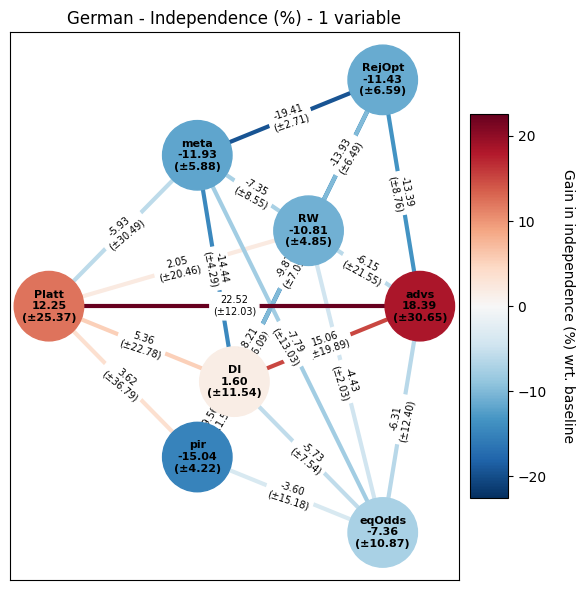

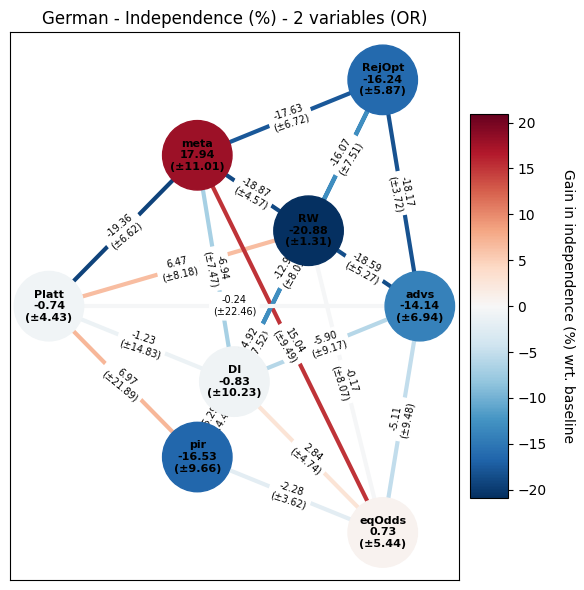

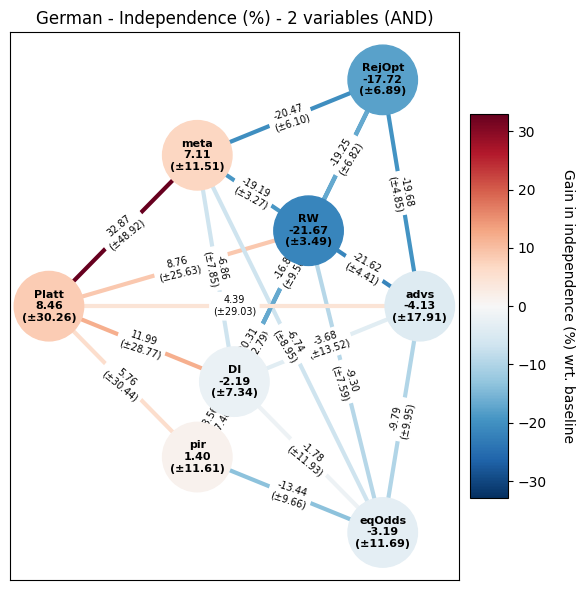

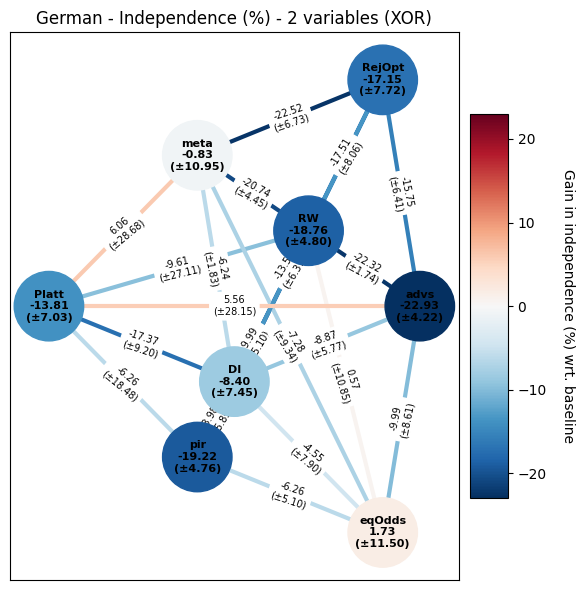

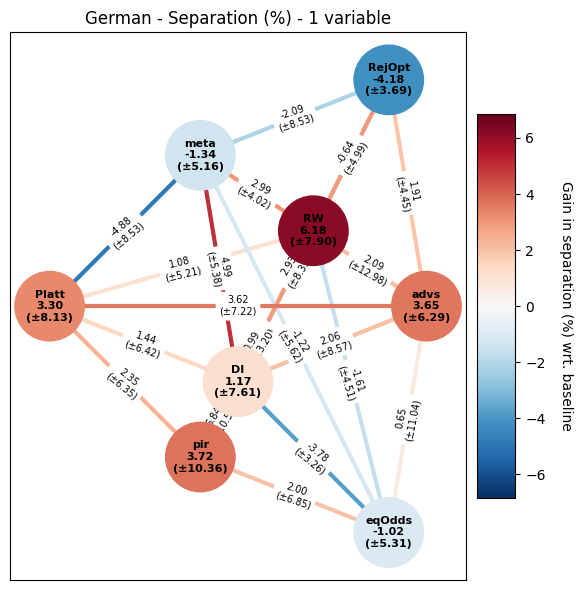

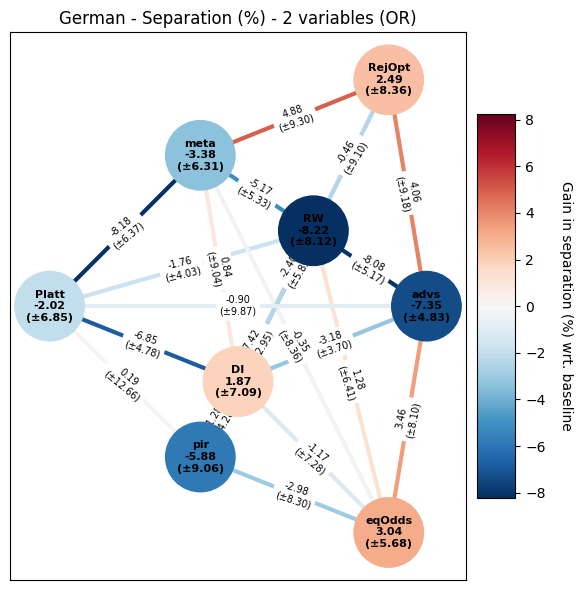

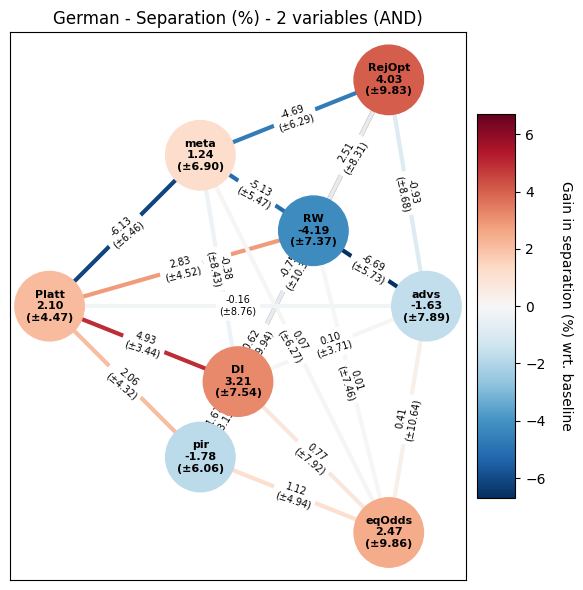

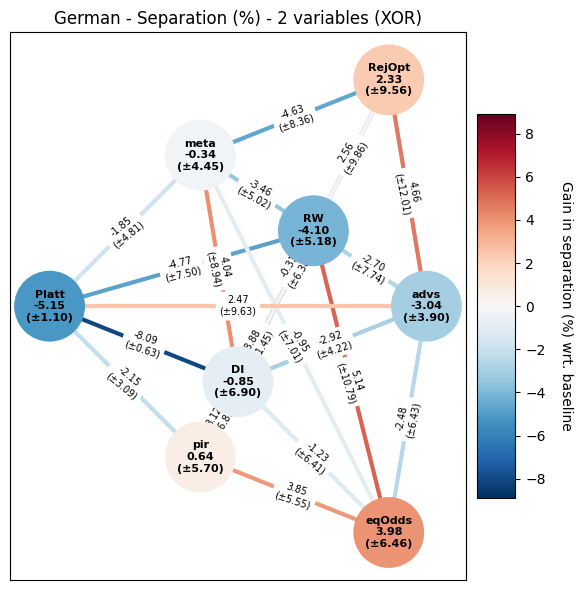

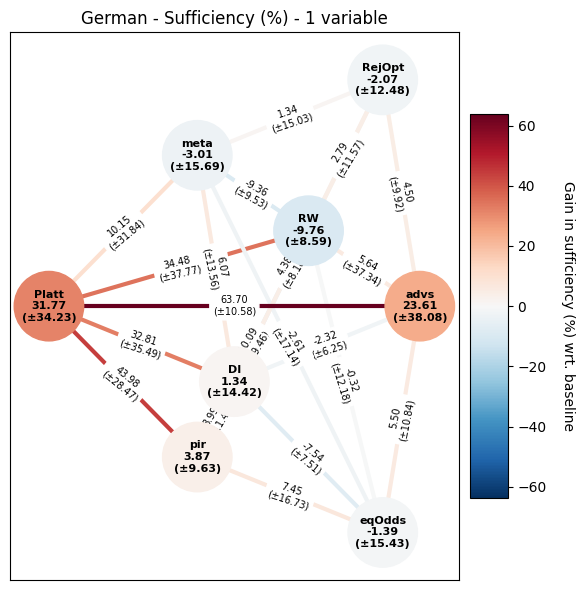

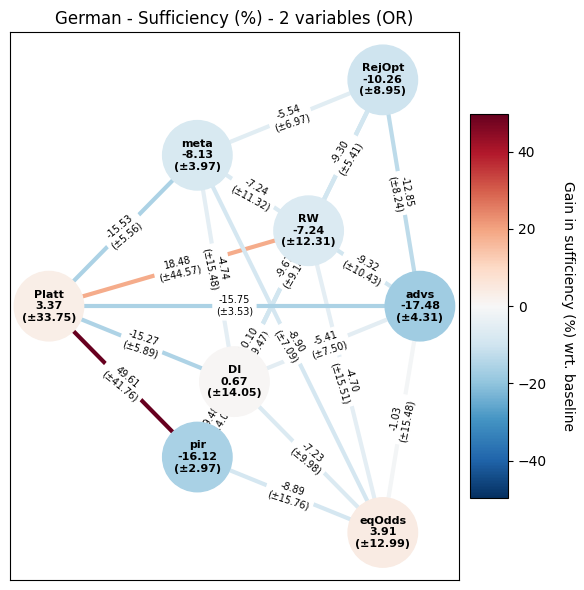

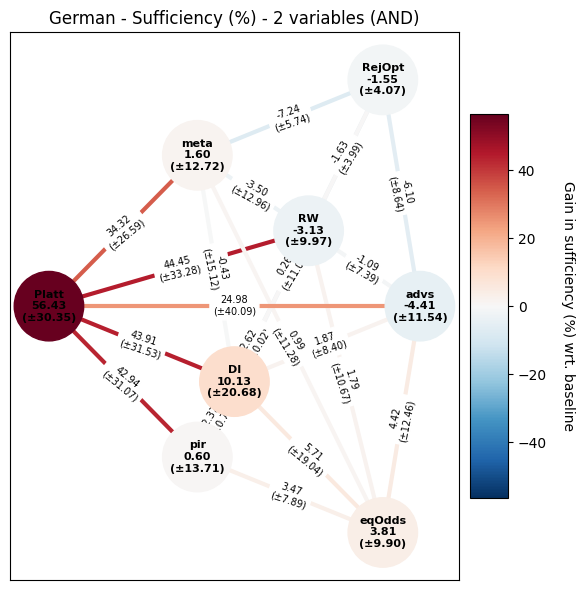

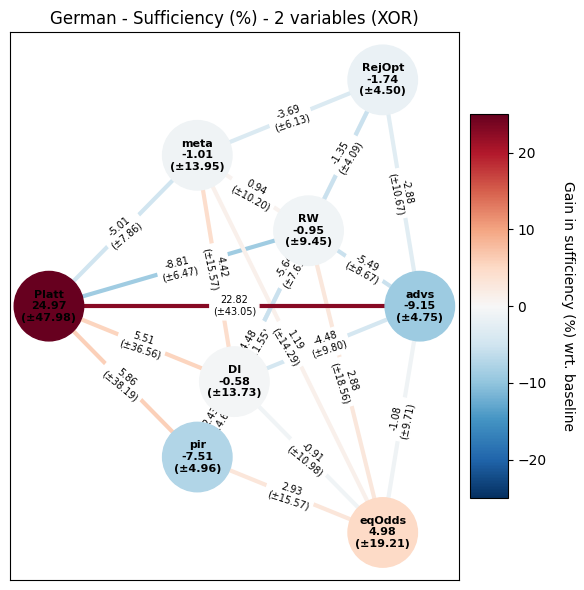

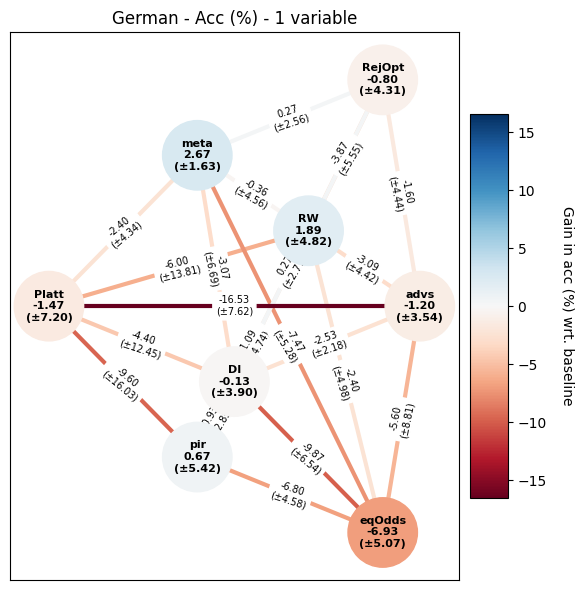

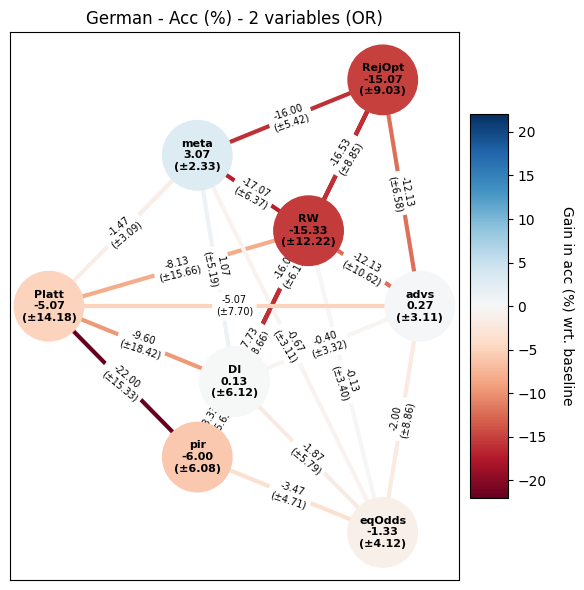

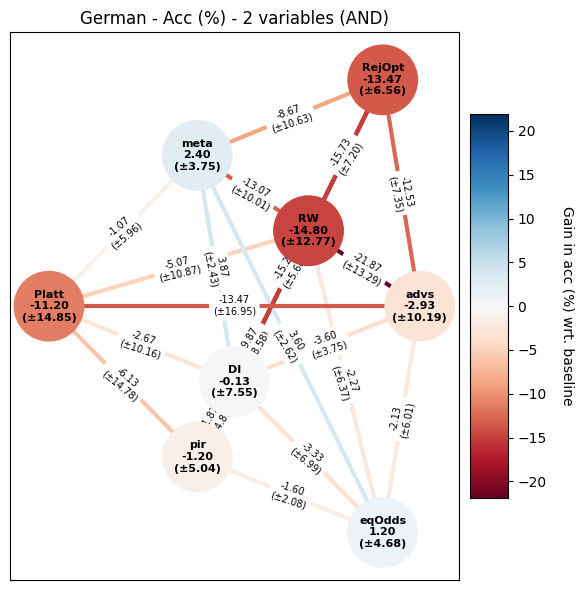

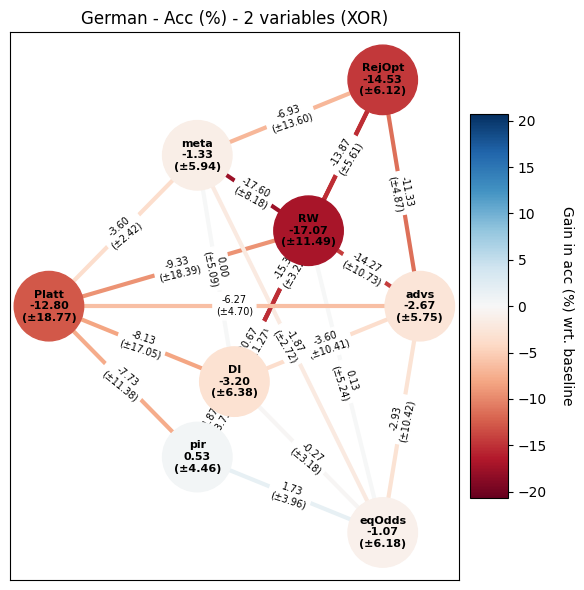

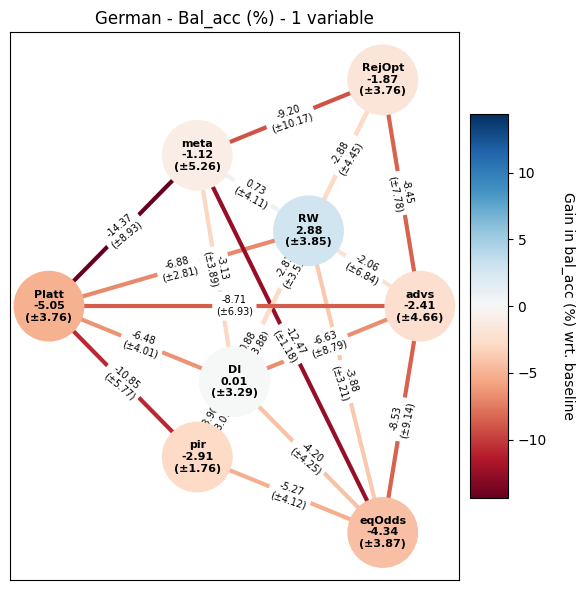

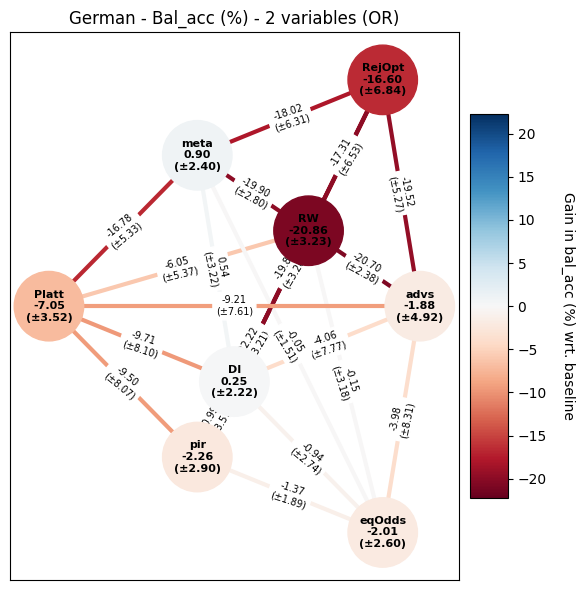

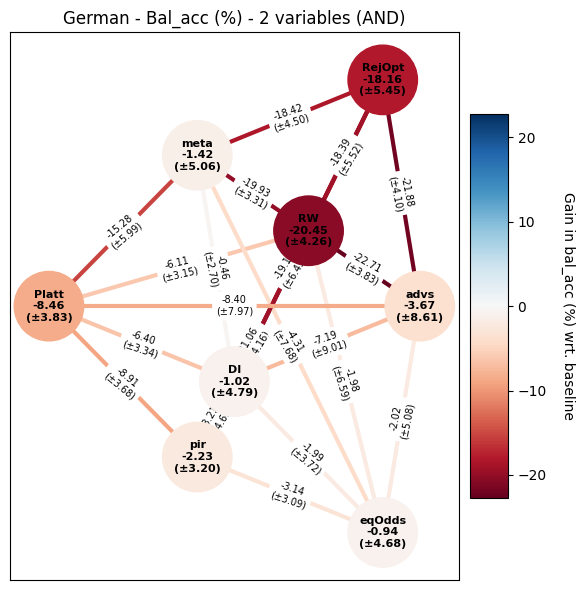

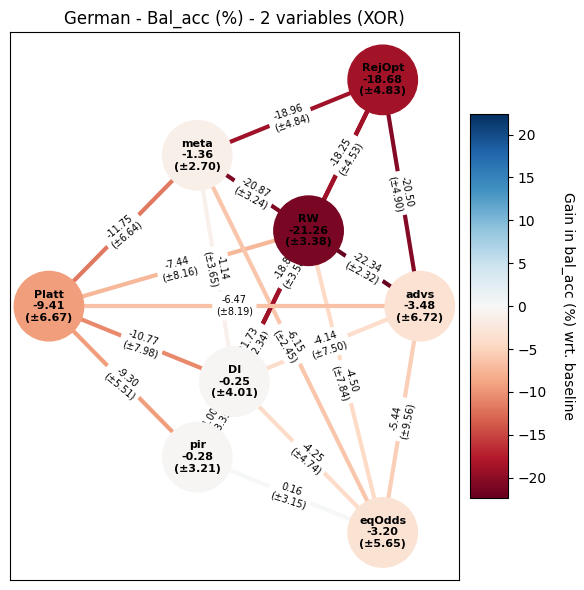

In [112]:
preproc = ['RW', 'DI']
inproc = ['meta', 'pir', 'advs']
postproc = ['Platt', 'eqOdds', 'RejOpt']

proc = preproc + inproc + postproc

for metric in metrics:

    if metric == 'acc' or metric == 'bal_acc':
        metric_n = 'accuracy'
        invert_color = True
    else:
        metric_n = metric
        invert_color = False

    graph_visualization(meanResults['German']['German1V_ind'], meanResults['German']['German1V_com'],
                        stdResults['German']['German1V_ind'], stdResults['German']['German1V_com'],
                        metric,
                        title = f"German - {metric.capitalize()} (%) - 1 variable", name_end = metric + "/German1V",
                        invert_color = invert_color)

    graph_visualization(meanResults['German']['German2V_OR_ind'], meanResults['German']['German2V_OR_com'],
                        stdResults['German']['German2V_OR_ind'], stdResults['German']['German2V_OR_com'],
                        metric,
                        title = f"German - {metric.capitalize()} (%) - 2 variables (OR)", name_end = metric + "/German2V_OR",
                        invert_color = invert_color)

    graph_visualization(meanResults['German']['German2V_AND_ind'], meanResults['German']['German2V_AND_com'],
                        stdResults['German']['German2V_AND_ind'], stdResults['German']['German2V_AND_com'],
                        metric,
                        title = f"German - {metric.capitalize()} (%) - 2 variables (AND)", name_end = metric + "/German2V_AND",
                        invert_color = invert_color)

    graph_visualization(meanResults['German']['German2V_XOR_ind'], meanResults['German']['German2V_XOR_com'],
                        stdResults['German']['German2V_XOR_ind'], stdResults['German']['German2V_XOR_com'],
                        metric,
                        title = f"German - {metric.capitalize()} (%) - 2 variables (XOR)", name_end = metric + "/German2V_XOR",
                        invert_color = invert_color)
